In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180.
yr = 365.25 # days / year

# Astrometric Orbits with Exoplanet

In the previous tutorial (:ref:`astrometric`) we showed how to fit an orbit with `exoplanet` where only astrometric information is available. In this notebook we'll extend that same example to also include the available radial velocity information on the system. 

## Data 
As before we'll use the astrometric and radial velocity measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract), and the radial velocities  are from [Tokovinin 1993](https://ui.adsabs.harvard.edu/#abs/1993AstL...19...73T/abstract). 

In [4]:
# grab the formatted data and do some munging

dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

rv1_data = ascii.read(dirname + "rv1.txt", format="csv")
rv2_data = ascii.read(dirname + "rv2.txt", format="csv")

In [5]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask) # eliminate entries with no measurements

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

# adjust the errors as before
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

In [6]:
# take out the data as only numpy arrays
rv1 = rv1_data["rv"].data
rv1_err = rv1_data["err"].data

rv2 = rv2_data["rv"].data
rv2_err = rv2_data["err"].data

# adapt the dates of the RV series 
rv1_dates = Time(rv1_data["date"] + 2400000, format="jd")
rv1_jds = rv1_dates.value
rv2_dates = Time(rv2_data["date"] + 2400000, format="jd")
rv2_jds = rv2_dates.value

rv1_yr = rv1_dates.decimalyear
rv2_yr = rv2_dates.decimalyear

As before, we'll plot $\rho$ vs. time and P.A. vs. time. We'll also add the RV time series for the primary and secondary stars.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


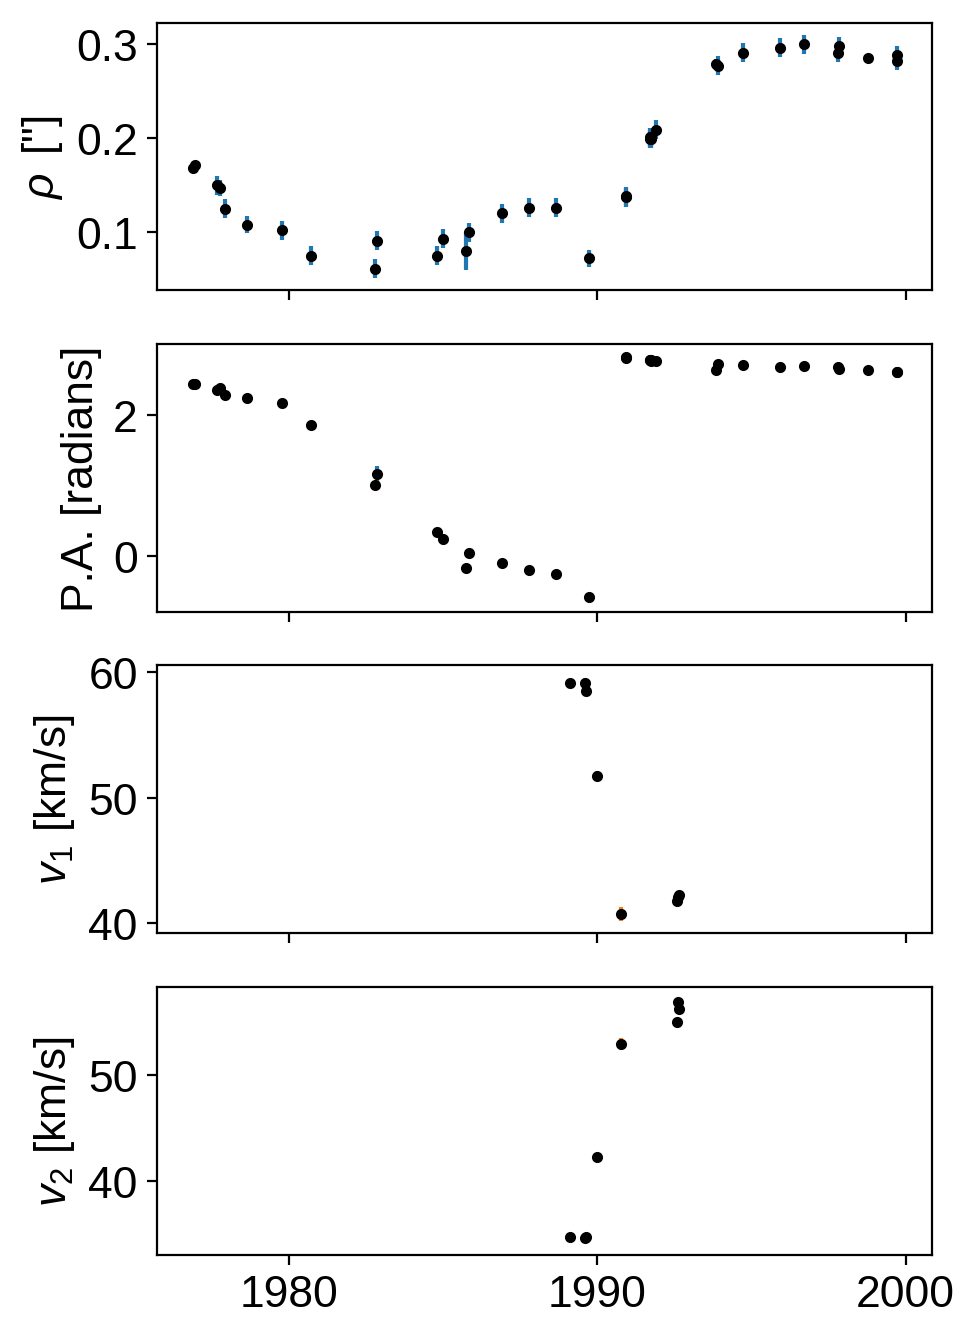

In [7]:
pkw = {"ls":"", "color":"k", "marker":"."}
ekw = {"ls":"", "color":"C1"}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(astro_yrs, rho_data, **pkw)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data, **pkw)
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(rv1_yr, rv1, **pkw)
ax[2].errorbar(rv1_yr, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(rv2_yr, rv2, **pkw)
ax[3].errorbar(rv2_yr, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

In [8]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

First, let's plot up a basic orbit with *exoplanet* to see if the best-fit parameters from Pourbaix et al. make sense. With the addition of radial velocity data, we can now constrain the masses of the stars. 

In [9]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [10]:
# Orbital elements from Pourbaix et al. 1998

# conversion constant
au_to_km = constants.au.to(u.km).value
au_to_R_sun = (constants.au / constants.R_sun).value

a_ang = 0.324 # arcsec
mparallax = 27.0 # milliarcsec 
parallax = 1e-3 * mparallax
a = a_ang / parallax # au

e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * yr # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

gamma = 47.8 # km/s; systemic velocity

# kappa = a1 / (a1 + a2)
kappa = 0.45 

# we parameterize exoplanet in terms of M2, so we'll need to 
# calculate Mtot from a, P, then M2 from Mtot and kappa
Mtot = calc_Mtot(a, P)
M2 = kappa * Mtot


# n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
# note that we now include M2 in the KeplerianOrbit initialization
orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=T0, period=P, 
                               incl=i, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

# make a theano function to get stuff from orbit 
times = tt.vector("times")
ang = orbit.get_relative_angles(times, parallax) # the rho, theta measurements

# convert from R_sun / day to km/s
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value
    
rv1_model = conv * orbit.get_star_velocity(times)[2] + gamma
rv2_model = conv * orbit.get_planet_velocity(times)[2] + gamma

f_ang = theano.function([times], ang)
f_rv1 = theano.function([times], rv1_model)
f_rv2 = theano.function([times], rv2_model)

t = np.linspace(T0 - 0.5 * P, T0 + 0.5 * P, num=2000) # days

rho_model, theta_model = f_ang(t)

rv1s = f_rv1(t)
rv2s = f_rv2(t)

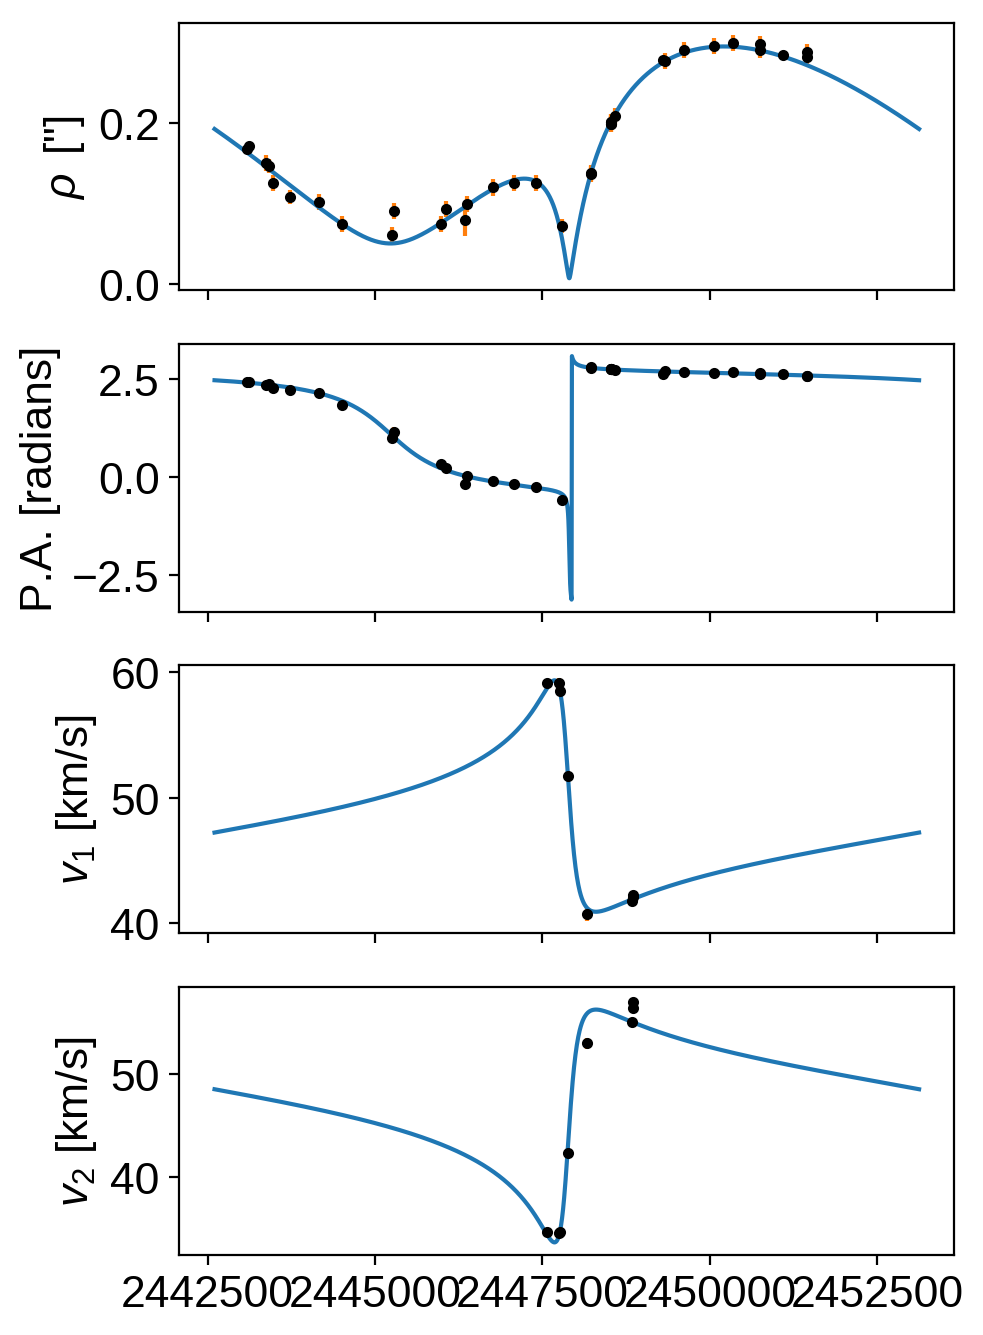

In [11]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(t, rho_model)
ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta_model)
ax[1].plot(astro_jds, theta_data, **pkw)
ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(t, rv1s)
ax[2].plot(rv1_jds, rv1, **pkw)
ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(t, rv2s)
ax[3].plot(rv2_jds, rv2, **pkw)
ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

It looks like a pretty good starting point. So, let's set up the model in PyMC3 for sampling.

In [12]:
# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

# for theta wrapping 
zeros = np.zeros_like(astro_jds)

# for predicted orbits
t_fine = np.linspace(astro_jds.min(), astro_jds.max(), num=1000)
rv_times = np.linspace(rv1_jds.min(), rv1_jds.max(), num=1000)

# for predicted sky orbits, spanning a full period
t_sky = np.linspace(0, 1, num=500)

with pm.Model() as model:

    # We'll include the parallax data as a prior on the parallax value     
    mparallax = pm.Normal("mparallax", mu=24.05, sd=0.45) # milliarcsec GAIA DR2
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP)) # days
    
    # Since we're doing an RV + astrometric fit, M2 now becomes a parameter of the model
    M2 = pm.Normal("M2", mu=1.0, sd=0.5) # solar masses
    
    gamma = pm.Normal("gamma", mu=47.8, sd=5.0) # km/s
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform on cos incl
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    # n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
    orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot = pm.Deterministic("Mtot", orbit.m_total)
    M1 = pm.Deterministic("M1", Mtot - M2)
    
    # get the astrometric predictions
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
        
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # evaluate the astrometric likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)

    # get the radial velocity predictions    
    # get_star_velocity and get_planet_velocity return (v_x, v_y, v_z) tuples, so we only need the v_z vector
    # but, note that since +Z points towards the observer, we actually want v_radial = -v_Z (see conv)
    # this is handled naturally by exoplanets get_radial_velocity (of the star), but since we also want
    # the "planet" velocity, or the velocity of the secondary, we queried both in this manner to be consistent
    rv1_model = conv * orbit.get_star_velocity(rv1_jds)[2] + gamma
    rv2_model = conv * orbit.get_planet_velocity(rv2_jds)[2] + gamma
    
    log_rv1_s = pm.Normal("logRV1S", mu=np.log(np.median(rv1_err)), sd=5.0)
    log_rv2_s = pm.Normal("logRV2S", mu=np.log(np.median(rv2_err)), sd=5.0)
    
    rv1_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv1_s))
    rv2_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv2_s))
    
    pm.Normal("obs_rv1", mu=rv1, observed=rv1_model, sd=rv1_tot_err)
    pm.Normal("obs_rv2", mu=rv2, observed=rv2_model, sd=rv2_tot_err)
    
    # save for future sep, pa, and RV plots 
    rho_dense, theta_dense = orbit.get_relative_angles(t_fine, parallax)
    rho_save = pm.Deterministic("rhoSave", rho_dense)
    theta_save = pm.Deterministic("thetaSave", theta_dense)    
    
    rv1_dense = pm.Deterministic("rv1Save", conv * orbit.get_star_velocity(rv_times)[2] + gamma)
    rv2_dense = pm.Deterministic("rv2Save", conv * orbit.get_planet_velocity(rv_times)[2] + gamma)
    
    # sky plots
    t_period = pm.Deterministic("tPeriod", t_sky * P + t_periastron)
    
    # save some samples on a fine orbit for sky plotting purposes
    rho, theta = orbit.get_relative_angles(t_period, parallax)
    rho_save_sky = pm.Deterministic("rhoSaveSky", rho)
    theta_save_sky = pm.Deterministic("thetaSaveSky", theta)

In [13]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logRV2S', 'logRV1S', 'logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'gamma', 'M2', 'logP_interval__', 'a_ang_interval__', 'mparallax']


message: Desired error not necessarily achieved due to precision loss.
logp: -181.75633483899398 -> 171.06970010730316


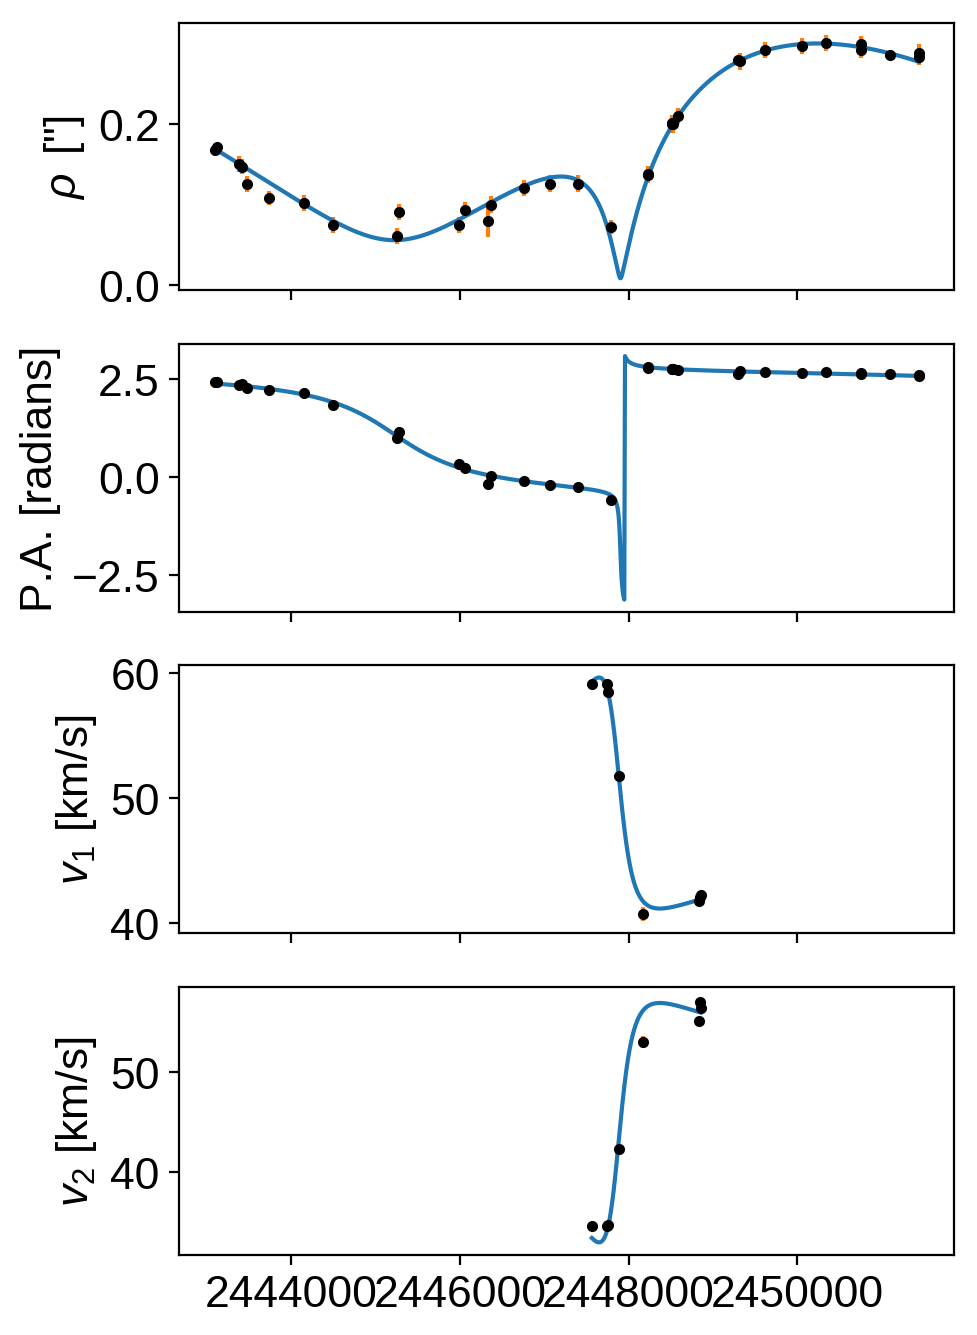

In [14]:
with model:

    fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
    ax[0].plot(t_fine, xo.eval_in_model(rho_save, map_sol))
    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
    ax[0].set_ylabel(r'$\rho\,$ ["]')

    ax[1].plot(t_fine, xo.eval_in_model(theta_save, map_sol))
    ax[1].plot(astro_jds, theta_data, **pkw)
    ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
    ax[1].set_ylabel(r'P.A. [radians]');

    ax[2].plot(rv_times, xo.eval_in_model(rv1_dense, map_sol))
    ax[2].plot(rv1_jds, rv1, **pkw)
    ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
    ax[2].set_ylabel(r"$v_1$ [km/s]")

    ax[3].plot(rv_times, xo.eval_in_model(rv2_dense, map_sol))
    ax[3].plot(rv2_jds, rv2, **pkw)
    ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
    ax[3].set_ylabel(r"$v_2$ [km/s]");

In [15]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=map_sol,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:08, 89.15draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:12, 63.76draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:14, 53.18draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:16, 47.67draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:17, 44.44draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:00<00:18, 42.42draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:18, 41.10draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:00<00:19, 40.25draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:19, 39.66draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:01<00:19, 38.50draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:01<00:19, 37.79draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:01<00:20, 37.30draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:01<00:20, 36.99draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:01<00:20, 36.79draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:20, 36.63draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:01<00:20, 36.70draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:01<00:19, 36.99draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:01<00:19, 37.31draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:02<00:19, 37.48draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:02<00:19, 37.75draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:02<00:18, 37.95draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:02<00:18, 38.10draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:02<00:18, 38.20draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:02<00:18, 38.26draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:02<00:18, 38.22draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:02<00:18, 38.23draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:02<00:18, 37.56draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:03<00:18, 37.81draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:03<00:17, 38.00draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:03<00:17, 38.13draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:03<00:17, 37.93draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:03<00:17, 37.51draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:03<00:17, 37.16draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:03<00:17, 36.90draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:03<00:17, 36.71draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:03<00:17, 36.59draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:03<00:17, 36.53draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:04<00:18, 34.85draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:04<00:18, 35.26draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:04<00:17, 35.59draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:04<00:17, 35.82draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:04<00:17, 35.98draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:04<00:17, 36.10draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:04<00:16, 38.78draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:04<00:16, 36.69draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:04<00:16, 37.23draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:05<00:16, 37.59draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:05<00:15, 37.88draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:05<00:15, 38.07draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:05<00:15, 38.22draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:05<00:15, 38.30draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:05<00:15, 38.37draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:05<00:15, 38.09draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:05<00:15, 38.22draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:05<00:15, 38.27draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:06<00:14, 38.34draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:06<00:14, 38.08draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:06<00:15, 37.61draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:06<00:15, 37.20draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:06<00:14, 38.37draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:06<00:14, 38.22draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:06<00:14, 38.08draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:06<00:14, 37.85draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:06<00:14, 37.67draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:07<00:14, 37.72draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:07<00:14, 37.61draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:07<00:14, 37.48draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:07<00:14, 37.41draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:07<00:14, 36.91draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:07<00:13, 37.11draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:07<00:14, 36.62draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:07<00:13, 36.93draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:07<00:13, 37.17draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:07<00:13, 37.31draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:08<00:13, 37.45draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:08<00:13, 37.50draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:08<00:13, 37.54draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:08<00:12, 37.61draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:08<00:12, 37.63draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:08<00:12, 37.69draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:08<00:12, 37.71draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:08<00:12, 37.68draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:08<00:12, 37.47draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:09<00:12, 37.50draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:09<00:12, 37.10draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:09<00:12, 36.87draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:09<00:12, 36.69draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:09<00:12, 36.55draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:09<00:12, 36.50draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:09<00:11, 36.44draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:09<00:11, 36.40draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:09<00:11, 36.39draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:10<00:11, 36.04draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:10<00:11, 36.13draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:10<00:11, 36.20draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:10<00:11, 36.25draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:10<00:11, 36.28draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:10<00:11, 36.30draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:10<00:11, 36.33draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [00:10<00:10, 36.38draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:10<00:10, 35.82draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:11<00:10, 36.02draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:11<00:10, 36.16draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:11<00:10, 36.26draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:11<00:10, 36.33draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:11<00:10, 36.06draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:11<00:10, 36.16draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:11<00:10, 36.25draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:11<00:09, 36.42draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:11<00:09, 36.88draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [00:12<00:09, 37.21draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:12<00:09, 37.44draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:12<00:09, 37.60draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:12<00:09, 37.70draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:12<00:08, 37.78draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:12<00:08, 37.83draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:12<00:08, 37.87draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:12<00:08, 37.89draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:12<00:08, 37.88draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:12<00:08, 37.90draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:13<00:08, 37.91draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:13<00:08, 37.91draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:13<00:08, 37.92draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:13<00:07, 37.93draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:13<00:07, 37.95draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:13<00:07, 37.96draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:13<00:07, 37.88draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:13<00:07, 37.91draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:13<00:07, 37.93draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:14<00:07, 37.94draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [00:14<00:07, 37.96draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:14<00:07, 37.97draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:14<00:06, 37.97draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:14<00:06, 37.70draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:14<00:06, 37.47draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:14<00:06, 37.19draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:14<00:06, 37.41draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [00:14<00:06, 39.08draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:14<00:06, 38.27draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:15<00:06, 37.69draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:15<00:06, 37.29draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:15<00:06, 37.02draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:15<00:06, 35.15draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:15<00:06, 35.48draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [00:15<00:06, 35.75draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:15<00:05, 35.95draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:15<00:05, 36.08draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:16<00:05, 36.19draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:16<00:05, 36.27draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:16<00:05, 36.31draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:16<00:05, 36.35draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:16<00:05, 36.37draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [00:16<00:05, 36.45draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:16<00:04, 36.71draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [00:16<00:04, 36.32draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:16<00:04, 36.61draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [00:16<00:04, 36.87draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [00:17<00:04, 37.03draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [00:17<00:04, 37.15draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [00:17<00:04, 37.21draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:17<00:04, 37.30draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:17<00:03, 37.32draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:17<00:03, 37.34draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:17<00:03, 37.37draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [00:17<00:03, 37.38draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:17<00:03, 37.37draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:18<00:03, 37.48draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:18<00:03, 37.60draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:18<00:03, 37.69draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:18<00:03, 37.77draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:18<00:02, 37.83draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:18<00:02, 37.88draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:18<00:02, 37.91draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [00:18<00:02, 37.84draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:18<00:02, 37.68draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:19<00:02, 37.74draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:19<00:02, 37.60draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:19<00:02, 37.53draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:19<00:02, 37.45draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:19<00:02, 37.42draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:19<00:01, 37.39draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:19<00:01, 37.37draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:19<00:01, 37.36draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:19<00:01, 37.35draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:19<00:01, 37.05draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:20<00:01, 36.74draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:20<00:01, 36.72draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:20<00:01, 37.31draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:20<00:01, 37.26draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:20<00:00, 37.20draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:20<00:00, 36.99draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:20<00:00, 37.08draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:20<00:00, 36.92draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:20<00:00, 36.80draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:21<00:00, 36.70draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:21<00:00, 28.15draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:21<00:00, 24.20draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:21<00:00, 25.07draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:21<00:00, 16.54draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:22<00:00, 36.20draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:03, 110.17draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 66.64draws/s] 

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:07, 52.06draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:08, 46.27draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:08, 42.86draws/s]

Sampling 4 chains:  10%|▉         | 39/408 [00:00<00:08, 45.64draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:07, 48.25draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:00<00:07, 47.32draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:01<00:07, 46.95draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:01<00:07, 49.25draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:01<00:07, 45.67draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:01<00:07, 45.90draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:01<00:07, 46.07draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:01<00:07, 45.82draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:01<00:07, 43.14draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:01<00:06, 46.23draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:01<00:06, 46.19draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:02<00:06, 45.72draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:02<00:06, 45.83draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:02<00:06, 44.09draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:02<00:06, 43.52draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:02<00:06, 47.39draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:02<00:06, 45.22draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:02<00:06, 44.84draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:02<00:05, 47.29draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:02<00:05, 46.58draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:03<00:06, 38.09draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [00:03<00:06, 40.22draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:03<00:05, 42.04draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:03<00:05, 47.15draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:03<00:04, 47.79draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:03<00:04, 49.21draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:03<00:05, 42.82draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:04<00:05, 41.59draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:04<00:05, 42.00draws/s]

Sampling 4 chains:  49%|████▉     | 199/408 [00:04<00:04, 43.32draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:04<00:05, 40.26draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:04<00:04, 40.28draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:04<00:04, 41.80draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:04<00:04, 43.08draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:04<00:04, 44.11draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:04<00:04, 43.31draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:05<00:03, 44.24draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:05<00:03, 44.42draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:05<00:03, 44.93draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [00:05<00:03, 41.12draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:05<00:03, 42.66draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:05<00:03, 37.46draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:05<00:03, 37.28draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:05<00:03, 39.36draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:06<00:03, 40.93draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:06<00:03, 38.27draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:06<00:03, 40.09draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:06<00:02, 41.40draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:06<00:02, 42.35draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:06<00:02, 43.30draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [00:06<00:02, 43.82draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:06<00:02, 44.15draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:06<00:02, 45.33draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:07<00:01, 45.10draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:07<00:01, 44.95draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:07<00:01, 44.70draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:07<00:01, 46.11draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:07<00:01, 40.05draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:07<00:01, 40.25draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:07<00:01, 40.37draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:07<00:01, 41.76draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:08<00:01, 41.01draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:08<00:01, 42.57draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:08<00:00, 42.86draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:08<00:00, 43.16draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:08<00:00, 43.52draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:08<00:00, 44.11draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [00:08<00:00, 39.08draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:08<00:00, 36.88draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:09<00:00, 36.53draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:09<00:00, 34.77draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:09<00:00, 19.92draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:09<00:00, 41.24draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:00<00:05, 157.34draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:00<00:04, 176.88draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:00<00:03, 208.57draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:00<00:02, 237.29draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:00<00:02, 261.98draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:00<00:02, 288.11draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:00<00:01, 303.12draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:00<00:01, 320.15draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:00<00:01, 334.69draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:01<00:01, 334.53draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:01<00:01, 331.37draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:01<00:01, 329.87draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:01<00:01, 349.92draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [00:01<00:00, 360.56draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:01<00:00, 342.30draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:01<00:00, 336.98draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:01<00:00, 334.58draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:01<00:00, 331.60draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:01<00:00, 335.01draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:02<00:00, 320.50draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:02<00:00, 306.96draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:02<00:00, 292.65draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:02<00:00, 276.99draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 305.38draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:00<00:07, 208.69draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:00<00:07, 214.17draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:00<00:06, 227.33draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:00<00:06, 248.87draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:00<00:06, 226.05draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:00<00:06, 222.73draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:00<00:06, 213.83draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:00<00:07, 198.17draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:00<00:06, 213.36draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:01<00:06, 212.96draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:01<00:06, 213.67draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:01<00:06, 205.49draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:01<00:06, 213.73draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [00:01<00:05, 231.02draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:01<00:05, 227.70draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [00:01<00:04, 248.89draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [00:01<00:04, 263.64draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [00:01<00:04, 244.99draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [00:02<00:04, 237.81draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [00:02<00:04, 235.74draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [00:02<00:04, 250.02draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [00:02<00:04, 253.59draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [00:02<00:04, 253.02draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [00:02<00:03, 256.15draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [00:02<00:03, 246.67draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [00:02<00:03, 255.68draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [00:02<00:03, 261.76draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [00:02<00:03, 261.33draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [00:03<00:03, 271.66draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [00:03<00:03, 272.10draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [00:03<00:02, 277.96draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [00:03<00:02, 285.22draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [00:03<00:02, 278.78draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [00:03<00:02, 280.81draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [00:03<00:02, 291.08draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [00:03<00:02, 275.31draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [00:03<00:02, 255.77draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [00:04<00:02, 249.52draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [00:04<00:02, 257.81draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [00:04<00:01, 270.68draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [00:04<00:01, 258.40draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [00:04<00:01, 269.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [00:04<00:01, 277.50draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [00:04<00:01, 291.78draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [00:04<00:01, 287.38draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [00:04<00:01, 285.55draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [00:05<00:01, 275.64draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [00:05<00:00, 288.87draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [00:05<00:00, 281.44draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [00:05<00:00, 278.52draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [00:05<00:00, 275.92draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [00:05<00:00, 270.76draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [00:05<00:00, 256.71draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [00:05<00:00, 256.50draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [00:05<00:00, 270.96draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [00:06<00:00, 244.72draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [00:06<00:00, 160.95draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [00:06<00:00, 110.38draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:06<00:00, 236.29draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:00<00:15, 207.41draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:00<00:15, 204.58draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:00<00:16, 192.77draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:00<00:14, 213.46draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:00<00:13, 224.43draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:00<00:13, 225.30draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:00<00:13, 224.72draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:00<00:13, 217.66draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [00:00<00:14, 212.94draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:01<00:13, 223.09draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:01<00:12, 232.65draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [00:01<00:11, 244.24draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:01<00:11, 242.08draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:01<00:11, 242.19draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [00:01<00:11, 254.10draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:01<00:11, 252.95draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [00:01<00:10, 256.59draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [00:01<00:12, 224.60draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [00:02<00:12, 223.94draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [00:02<00:12, 225.07draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [00:02<00:11, 236.07draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [00:02<00:10, 253.87draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [00:02<00:09, 271.70draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [00:02<00:10, 240.50draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [00:02<00:10, 252.08draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [00:02<00:09, 266.68draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [00:02<00:10, 243.93draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [00:03<00:10, 231.63draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [00:03<00:10, 224.85draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [00:03<00:10, 228.24draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [00:03<00:10, 233.32draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [00:03<00:10, 236.10draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [00:03<00:09, 237.17draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [00:03<00:09, 236.23draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [00:03<00:09, 244.95draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [00:03<00:09, 248.86draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [00:03<00:08, 268.27draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [00:04<00:07, 278.21draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [00:04<00:07, 274.20draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [00:04<00:08, 268.55draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [00:04<00:07, 270.55draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [00:04<00:08, 262.63draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [00:04<00:08, 257.64draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [00:04<00:07, 262.26draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [00:04<00:07, 256.45draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [00:04<00:08, 238.82draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [00:05<00:08, 241.64draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [00:05<00:08, 240.59draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [00:05<00:07, 245.26draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [00:05<00:07, 245.77draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [00:05<00:07, 245.99draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [00:05<00:07, 254.96draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [00:05<00:06, 267.41draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [00:05<00:06, 264.28draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [00:05<00:06, 257.35draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [00:05<00:06, 262.34draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [00:06<00:06, 263.85draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [00:06<00:06, 263.78draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [00:06<00:06, 260.26draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [00:06<00:06, 266.28draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [00:06<00:05, 267.11draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [00:06<00:05, 282.11draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [00:06<00:05, 282.31draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [00:06<00:05, 277.11draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [00:06<00:05, 284.49draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [00:07<00:05, 271.11draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [00:07<00:04, 282.62draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [00:07<00:04, 281.13draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [00:07<00:04, 282.93draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [00:07<00:04, 278.58draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [00:07<00:04, 277.75draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [00:07<00:04, 285.99draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [00:07<00:04, 285.17draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [00:07<00:04, 290.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [00:07<00:04, 282.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [00:08<00:04, 282.74draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [00:08<00:03, 284.03draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [00:08<00:03, 288.63draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [00:08<00:03, 274.03draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [00:08<00:03, 269.08draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [00:08<00:03, 269.60draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [00:08<00:03, 261.53draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [00:08<00:03, 264.22draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [00:08<00:03, 269.93draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [00:09<00:03, 272.68draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [00:09<00:03, 271.77draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [00:09<00:02, 281.74draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [00:09<00:02, 287.58draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [00:09<00:02, 291.89draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [00:09<00:02, 288.16draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [00:09<00:02, 291.07draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [00:09<00:02, 293.49draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [00:09<00:02, 287.10draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [00:09<00:02, 275.20draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [00:10<00:02, 269.35draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [00:10<00:02, 258.75draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [00:10<00:02, 253.70draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [00:10<00:01, 256.97draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [00:10<00:01, 269.67draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [00:10<00:01, 271.54draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [00:10<00:01, 285.70draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [00:10<00:01, 292.15draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [00:10<00:01, 291.77draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [00:11<00:01, 292.04draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [00:11<00:01, 287.52draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [00:11<00:00, 281.00draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [00:11<00:00, 275.96draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [00:11<00:00, 275.17draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [00:11<00:00, 277.90draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [00:11<00:00, 282.98draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [00:11<00:00, 281.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [00:11<00:00, 278.34draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [00:12<00:00, 234.92draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [00:12<00:00, 179.83draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [00:12<00:00, 119.06draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:12<00:00, 250.61draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/9208 [00:00<00:45, 202.77draws/s]

Sampling 4 chains:   0%|          | 44/9208 [00:00<00:43, 208.90draws/s]

Sampling 4 chains:   1%|          | 68/9208 [00:00<00:42, 214.64draws/s]

Sampling 4 chains:   1%|          | 100/9208 [00:00<00:38, 237.42draws/s]

Sampling 4 chains:   1%|▏         | 121/9208 [00:00<00:39, 227.96draws/s]

Sampling 4 chains:   2%|▏         | 145/9208 [00:00<00:39, 228.80draws/s]

Sampling 4 chains:   2%|▏         | 172/9208 [00:00<00:37, 238.25draws/s]

Sampling 4 chains:   2%|▏         | 206/9208 [00:00<00:34, 260.13draws/s]

Sampling 4 chains:   3%|▎         | 232/9208 [00:00<00:39, 225.13draws/s]

Sampling 4 chains:   3%|▎         | 256/9208 [00:01<00:40, 221.93draws/s]

Sampling 4 chains:   3%|▎         | 284/9208 [00:01<00:37, 236.54draws/s]

Sampling 4 chains:   3%|▎         | 309/9208 [00:01<00:39, 228.09draws/s]

Sampling 4 chains:   4%|▎         | 334/9208 [00:01<00:38, 233.07draws/s]

Sampling 4 chains:   4%|▍         | 359/9208 [00:01<00:37, 236.87draws/s]

Sampling 4 chains:   4%|▍         | 383/9208 [00:01<00:38, 228.73draws/s]

Sampling 4 chains:   4%|▍         | 408/9208 [00:01<00:37, 233.30draws/s]

Sampling 4 chains:   5%|▍         | 436/9208 [00:01<00:36, 242.33draws/s]

Sampling 4 chains:   5%|▌         | 463/9208 [00:01<00:35, 245.86draws/s]

Sampling 4 chains:   5%|▌         | 488/9208 [00:02<00:37, 233.00draws/s]

Sampling 4 chains:   6%|▌         | 514/9208 [00:02<00:36, 239.29draws/s]

Sampling 4 chains:   6%|▌         | 539/9208 [00:02<00:37, 232.87draws/s]

Sampling 4 chains:   6%|▌         | 565/9208 [00:02<00:36, 239.62draws/s]

Sampling 4 chains:   6%|▋         | 590/9208 [00:02<00:35, 240.48draws/s]

Sampling 4 chains:   7%|▋         | 616/9208 [00:02<00:35, 245.18draws/s]

Sampling 4 chains:   7%|▋         | 644/9208 [00:02<00:34, 250.89draws/s]

Sampling 4 chains:   7%|▋         | 671/9208 [00:02<00:33, 254.85draws/s]

Sampling 4 chains:   8%|▊         | 705/9208 [00:02<00:30, 274.73draws/s]

Sampling 4 chains:   8%|▊         | 739/9208 [00:02<00:29, 290.98draws/s]

Sampling 4 chains:   8%|▊         | 769/9208 [00:03<00:30, 274.69draws/s]

Sampling 4 chains:   9%|▊         | 798/9208 [00:03<00:32, 261.15draws/s]

Sampling 4 chains:   9%|▉         | 825/9208 [00:03<00:33, 251.28draws/s]

Sampling 4 chains:   9%|▉         | 851/9208 [00:03<00:33, 252.44draws/s]

Sampling 4 chains:  10%|▉         | 878/9208 [00:03<00:32, 253.91draws/s]

Sampling 4 chains:  10%|▉         | 908/9208 [00:03<00:31, 263.40draws/s]

Sampling 4 chains:  10%|█         | 935/9208 [00:03<00:31, 262.98draws/s]

Sampling 4 chains:  10%|█         | 962/9208 [00:03<00:32, 257.16draws/s]

Sampling 4 chains:  11%|█         | 988/9208 [00:03<00:33, 242.00draws/s]

Sampling 4 chains:  11%|█         | 1013/9208 [00:04<00:34, 239.98draws/s]

Sampling 4 chains:  11%|█▏        | 1042/9208 [00:04<00:32, 252.31draws/s]

Sampling 4 chains:  12%|█▏        | 1070/9208 [00:04<00:31, 259.38draws/s]

Sampling 4 chains:  12%|█▏        | 1098/9208 [00:04<00:30, 262.26draws/s]

Sampling 4 chains:  12%|█▏        | 1125/9208 [00:04<00:31, 259.84draws/s]

Sampling 4 chains:  13%|█▎        | 1152/9208 [00:04<00:30, 262.55draws/s]

Sampling 4 chains:  13%|█▎        | 1182/9208 [00:04<00:29, 267.60draws/s]

Sampling 4 chains:  13%|█▎        | 1211/9208 [00:04<00:29, 272.00draws/s]

Sampling 4 chains:  13%|█▎        | 1240/9208 [00:04<00:28, 275.18draws/s]

Sampling 4 chains:  14%|█▍        | 1268/9208 [00:05<00:29, 269.99draws/s]

Sampling 4 chains:  14%|█▍        | 1296/9208 [00:05<00:29, 268.44draws/s]

Sampling 4 chains:  14%|█▍        | 1323/9208 [00:05<00:29, 264.23draws/s]

Sampling 4 chains:  15%|█▍        | 1351/9208 [00:05<00:29, 267.95draws/s]

Sampling 4 chains:  15%|█▍        | 1378/9208 [00:05<00:31, 251.25draws/s]

Sampling 4 chains:  15%|█▌        | 1404/9208 [00:05<00:31, 250.47draws/s]

Sampling 4 chains:  16%|█▌        | 1430/9208 [00:05<00:32, 241.19draws/s]

Sampling 4 chains:  16%|█▌        | 1455/9208 [00:05<00:32, 238.70draws/s]

Sampling 4 chains:  16%|█▌        | 1484/9208 [00:05<00:30, 252.01draws/s]

Sampling 4 chains:  16%|█▋        | 1510/9208 [00:06<00:30, 251.15draws/s]

Sampling 4 chains:  17%|█▋        | 1539/9208 [00:06<00:29, 261.01draws/s]

Sampling 4 chains:  17%|█▋        | 1567/9208 [00:06<00:28, 265.32draws/s]

Sampling 4 chains:  17%|█▋        | 1597/9208 [00:06<00:27, 273.28draws/s]

Sampling 4 chains:  18%|█▊        | 1625/9208 [00:06<00:27, 273.53draws/s]

Sampling 4 chains:  18%|█▊        | 1653/9208 [00:06<00:28, 268.95draws/s]

Sampling 4 chains:  18%|█▊        | 1681/9208 [00:06<00:29, 254.86draws/s]

Sampling 4 chains:  19%|█▊        | 1707/9208 [00:06<00:30, 245.27draws/s]

Sampling 4 chains:  19%|█▉        | 1732/9208 [00:06<00:32, 230.14draws/s]

Sampling 4 chains:  19%|█▉        | 1759/9208 [00:06<00:31, 237.14draws/s]

Sampling 4 chains:  19%|█▉        | 1784/9208 [00:07<00:31, 236.78draws/s]

Sampling 4 chains:  20%|█▉        | 1813/9208 [00:07<00:29, 248.10draws/s]

Sampling 4 chains:  20%|█▉        | 1840/9208 [00:07<00:29, 253.53draws/s]

Sampling 4 chains:  20%|██        | 1868/9208 [00:07<00:28, 258.78draws/s]

Sampling 4 chains:  21%|██        | 1895/9208 [00:07<00:28, 253.99draws/s]

Sampling 4 chains:  21%|██        | 1921/9208 [00:07<00:30, 241.22draws/s]

Sampling 4 chains:  21%|██        | 1946/9208 [00:07<00:29, 242.90draws/s]

Sampling 4 chains:  21%|██▏       | 1971/9208 [00:07<00:29, 244.49draws/s]

Sampling 4 chains:  22%|██▏       | 2000/9208 [00:07<00:28, 255.45draws/s]

Sampling 4 chains:  22%|██▏       | 2027/9208 [00:08<00:27, 259.44draws/s]

Sampling 4 chains:  22%|██▏       | 2054/9208 [00:08<00:27, 257.94draws/s]

Sampling 4 chains:  23%|██▎       | 2080/9208 [00:08<00:28, 246.37draws/s]

Sampling 4 chains:  23%|██▎       | 2107/9208 [00:08<00:28, 252.26draws/s]

Sampling 4 chains:  23%|██▎       | 2136/9208 [00:08<00:27, 258.67draws/s]

Sampling 4 chains:  24%|██▎       | 2165/9208 [00:08<00:26, 264.58draws/s]

Sampling 4 chains:  24%|██▍       | 2195/9208 [00:08<00:25, 274.16draws/s]

Sampling 4 chains:  24%|██▍       | 2223/9208 [00:08<00:25, 272.01draws/s]

Sampling 4 chains:  24%|██▍       | 2251/9208 [00:08<00:25, 273.05draws/s]

Sampling 4 chains:  25%|██▍       | 2280/9208 [00:08<00:25, 276.85draws/s]

Sampling 4 chains:  25%|██▌       | 2308/9208 [00:09<00:24, 276.42draws/s]

Sampling 4 chains:  25%|██▌       | 2340/9208 [00:09<00:24, 285.42draws/s]

Sampling 4 chains:  26%|██▌       | 2369/9208 [00:09<00:25, 271.29draws/s]

Sampling 4 chains:  26%|██▌       | 2397/9208 [00:09<00:25, 271.47draws/s]

Sampling 4 chains:  26%|██▋       | 2426/9208 [00:09<00:24, 272.95draws/s]

Sampling 4 chains:  27%|██▋       | 2454/9208 [00:09<00:24, 271.61draws/s]

Sampling 4 chains:  27%|██▋       | 2484/9208 [00:09<00:24, 279.27draws/s]

Sampling 4 chains:  27%|██▋       | 2513/9208 [00:09<00:23, 282.15draws/s]

Sampling 4 chains:  28%|██▊       | 2543/9208 [00:09<00:23, 283.46draws/s]

Sampling 4 chains:  28%|██▊       | 2572/9208 [00:10<00:23, 281.92draws/s]

Sampling 4 chains:  28%|██▊       | 2601/9208 [00:10<00:23, 280.77draws/s]

Sampling 4 chains:  29%|██▊       | 2632/9208 [00:10<00:22, 288.03draws/s]

Sampling 4 chains:  29%|██▉       | 2661/9208 [00:10<00:23, 278.80draws/s]

Sampling 4 chains:  29%|██▉       | 2689/9208 [00:10<00:23, 274.95draws/s]

Sampling 4 chains:  30%|██▉       | 2717/9208 [00:10<00:24, 268.92draws/s]

Sampling 4 chains:  30%|██▉       | 2746/9208 [00:10<00:23, 273.86draws/s]

Sampling 4 chains:  30%|███       | 2774/9208 [00:10<00:23, 268.17draws/s]

Sampling 4 chains:  30%|███       | 2801/9208 [00:10<00:24, 264.38draws/s]

Sampling 4 chains:  31%|███       | 2828/9208 [00:10<00:24, 261.24draws/s]

Sampling 4 chains:  31%|███       | 2855/9208 [00:11<00:24, 262.69draws/s]

Sampling 4 chains:  31%|███▏      | 2885/9208 [00:11<00:23, 268.91draws/s]

Sampling 4 chains:  32%|███▏      | 2913/9208 [00:11<00:23, 267.55draws/s]

Sampling 4 chains:  32%|███▏      | 2940/9208 [00:11<00:23, 265.16draws/s]

Sampling 4 chains:  32%|███▏      | 2969/9208 [00:11<00:23, 269.04draws/s]

Sampling 4 chains:  33%|███▎      | 2996/9208 [00:11<00:23, 268.99draws/s]

Sampling 4 chains:  33%|███▎      | 3023/9208 [00:11<00:23, 260.51draws/s]

Sampling 4 chains:  33%|███▎      | 3050/9208 [00:11<00:23, 259.28draws/s]

Sampling 4 chains:  33%|███▎      | 3077/9208 [00:11<00:23, 261.79draws/s]

Sampling 4 chains:  34%|███▎      | 3107/9208 [00:12<00:22, 271.08draws/s]

Sampling 4 chains:  34%|███▍      | 3137/9208 [00:12<00:22, 275.29draws/s]

Sampling 4 chains:  34%|███▍      | 3165/9208 [00:12<00:22, 263.25draws/s]

Sampling 4 chains:  35%|███▍      | 3192/9208 [00:12<00:23, 258.21draws/s]

Sampling 4 chains:  35%|███▍      | 3218/9208 [00:12<00:23, 258.40draws/s]

Sampling 4 chains:  35%|███▌      | 3244/9208 [00:12<00:23, 253.20draws/s]

Sampling 4 chains:  36%|███▌      | 3271/9208 [00:12<00:23, 254.63draws/s]

Sampling 4 chains:  36%|███▌      | 3298/9208 [00:12<00:22, 258.90draws/s]

Sampling 4 chains:  36%|███▌      | 3325/9208 [00:12<00:22, 260.35draws/s]

Sampling 4 chains:  36%|███▋      | 3352/9208 [00:12<00:22, 261.62draws/s]

Sampling 4 chains:  37%|███▋      | 3379/9208 [00:13<00:22, 263.25draws/s]

Sampling 4 chains:  37%|███▋      | 3406/9208 [00:13<00:21, 264.73draws/s]

Sampling 4 chains:  37%|███▋      | 3436/9208 [00:13<00:21, 273.60draws/s]

Sampling 4 chains:  38%|███▊      | 3466/9208 [00:13<00:20, 279.69draws/s]

Sampling 4 chains:  38%|███▊      | 3495/9208 [00:13<00:20, 280.80draws/s]

Sampling 4 chains:  38%|███▊      | 3524/9208 [00:13<00:20, 277.27draws/s]

Sampling 4 chains:  39%|███▊      | 3552/9208 [00:13<00:20, 274.57draws/s]

Sampling 4 chains:  39%|███▉      | 3580/9208 [00:13<00:21, 264.17draws/s]

Sampling 4 chains:  39%|███▉      | 3607/9208 [00:13<00:22, 252.77draws/s]

Sampling 4 chains:  39%|███▉      | 3635/9208 [00:14<00:21, 260.11draws/s]

Sampling 4 chains:  40%|███▉      | 3662/9208 [00:14<00:21, 261.06draws/s]

Sampling 4 chains:  40%|████      | 3689/9208 [00:14<00:20, 263.06draws/s]

Sampling 4 chains:  40%|████      | 3720/9208 [00:14<00:20, 273.94draws/s]

Sampling 4 chains:  41%|████      | 3749/9208 [00:14<00:19, 277.91draws/s]

Sampling 4 chains:  41%|████      | 3780/9208 [00:14<00:19, 282.40draws/s]

Sampling 4 chains:  41%|████▏     | 3809/9208 [00:14<00:19, 283.32draws/s]

Sampling 4 chains:  42%|████▏     | 3838/9208 [00:14<00:19, 274.09draws/s]

Sampling 4 chains:  42%|████▏     | 3866/9208 [00:14<00:19, 272.47draws/s]

Sampling 4 chains:  42%|████▏     | 3895/9208 [00:14<00:19, 277.14draws/s]

Sampling 4 chains:  43%|████▎     | 3924/9208 [00:15<00:18, 279.64draws/s]

Sampling 4 chains:  43%|████▎     | 3954/9208 [00:15<00:18, 285.31draws/s]

Sampling 4 chains:  43%|████▎     | 3983/9208 [00:15<00:18, 275.58draws/s]

Sampling 4 chains:  44%|████▎     | 4011/9208 [00:15<00:19, 271.49draws/s]

Sampling 4 chains:  44%|████▍     | 4039/9208 [00:15<00:19, 268.49draws/s]

Sampling 4 chains:  44%|████▍     | 4068/9208 [00:15<00:19, 269.76draws/s]

Sampling 4 chains:  45%|████▍     | 4099/9208 [00:15<00:18, 280.07draws/s]

Sampling 4 chains:  45%|████▍     | 4132/9208 [00:15<00:17, 290.81draws/s]

Sampling 4 chains:  45%|████▌     | 4163/9208 [00:15<00:17, 294.58draws/s]

Sampling 4 chains:  46%|████▌     | 4193/9208 [00:15<00:16, 295.30draws/s]

Sampling 4 chains:  46%|████▌     | 4226/9208 [00:16<00:16, 304.58draws/s]

Sampling 4 chains:  46%|████▌     | 4257/9208 [00:16<00:16, 304.21draws/s]

Sampling 4 chains:  47%|████▋     | 4288/9208 [00:16<00:16, 294.25draws/s]

Sampling 4 chains:  47%|████▋     | 4318/9208 [00:16<00:16, 290.08draws/s]

Sampling 4 chains:  47%|████▋     | 4348/9208 [00:16<00:16, 287.16draws/s]

Sampling 4 chains:  48%|████▊     | 4377/9208 [00:16<00:17, 282.29draws/s]

Sampling 4 chains:  48%|████▊     | 4407/9208 [00:16<00:16, 285.11draws/s]

Sampling 4 chains:  48%|████▊     | 4439/9208 [00:16<00:16, 293.43draws/s]

Sampling 4 chains:  49%|████▊     | 4469/9208 [00:16<00:16, 289.02draws/s]

Sampling 4 chains:  49%|████▉     | 4499/9208 [00:17<00:16, 289.34draws/s]

Sampling 4 chains:  49%|████▉     | 4528/9208 [00:17<00:16, 276.10draws/s]

Sampling 4 chains:  50%|████▉     | 4558/9208 [00:17<00:16, 279.45draws/s]

Sampling 4 chains:  50%|████▉     | 4587/9208 [00:17<00:16, 278.61draws/s]

Sampling 4 chains:  50%|█████     | 4615/9208 [00:17<00:16, 276.72draws/s]

Sampling 4 chains:  50%|█████     | 4643/9208 [00:17<00:16, 274.73draws/s]

Sampling 4 chains:  51%|█████     | 4671/9208 [00:17<00:16, 273.12draws/s]

Sampling 4 chains:  51%|█████     | 4702/9208 [00:17<00:16, 279.92draws/s]

Sampling 4 chains:  51%|█████▏    | 4731/9208 [00:17<00:16, 277.26draws/s]

Sampling 4 chains:  52%|█████▏    | 4760/9208 [00:17<00:15, 278.03draws/s]

Sampling 4 chains:  52%|█████▏    | 4789/9208 [00:18<00:15, 279.88draws/s]

Sampling 4 chains:  52%|█████▏    | 4818/9208 [00:18<00:16, 269.62draws/s]

Sampling 4 chains:  53%|█████▎    | 4846/9208 [00:18<00:16, 259.15draws/s]

Sampling 4 chains:  53%|█████▎    | 4873/9208 [00:18<00:16, 261.67draws/s]

Sampling 4 chains:  53%|█████▎    | 4905/9208 [00:18<00:15, 274.90draws/s]

Sampling 4 chains:  54%|█████▎    | 4937/9208 [00:18<00:15, 284.18draws/s]

Sampling 4 chains:  54%|█████▍    | 4967/9208 [00:18<00:14, 283.10draws/s]

Sampling 4 chains:  54%|█████▍    | 4996/9208 [00:18<00:15, 279.68draws/s]

Sampling 4 chains:  55%|█████▍    | 5025/9208 [00:18<00:14, 279.12draws/s]

Sampling 4 chains:  55%|█████▍    | 5054/9208 [00:19<00:15, 272.61draws/s]

Sampling 4 chains:  55%|█████▌    | 5083/9208 [00:19<00:14, 277.45draws/s]

Sampling 4 chains:  56%|█████▌    | 5113/9208 [00:19<00:14, 281.46draws/s]

Sampling 4 chains:  56%|█████▌    | 5142/9208 [00:19<00:14, 279.48draws/s]

Sampling 4 chains:  56%|█████▌    | 5171/9208 [00:19<00:14, 280.60draws/s]

Sampling 4 chains:  56%|█████▋    | 5202/9208 [00:19<00:13, 287.48draws/s]

Sampling 4 chains:  57%|█████▋    | 5231/9208 [00:19<00:13, 284.21draws/s]

Sampling 4 chains:  57%|█████▋    | 5260/9208 [00:19<00:13, 282.26draws/s]

Sampling 4 chains:  57%|█████▋    | 5289/9208 [00:19<00:14, 279.61draws/s]

Sampling 4 chains:  58%|█████▊    | 5317/9208 [00:19<00:13, 278.87draws/s]

Sampling 4 chains:  58%|█████▊    | 5346/9208 [00:20<00:13, 281.30draws/s]

Sampling 4 chains:  58%|█████▊    | 5375/9208 [00:20<00:13, 283.61draws/s]

Sampling 4 chains:  59%|█████▊    | 5406/9208 [00:20<00:13, 290.85draws/s]

Sampling 4 chains:  59%|█████▉    | 5436/9208 [00:20<00:13, 289.55draws/s]

Sampling 4 chains:  59%|█████▉    | 5465/9208 [00:20<00:13, 285.49draws/s]

Sampling 4 chains:  60%|█████▉    | 5494/9208 [00:20<00:13, 277.14draws/s]

Sampling 4 chains:  60%|█████▉    | 5523/9208 [00:20<00:13, 279.31draws/s]

Sampling 4 chains:  60%|██████    | 5553/9208 [00:20<00:13, 279.75draws/s]

Sampling 4 chains:  61%|██████    | 5584/9208 [00:20<00:12, 285.71draws/s]

Sampling 4 chains:  61%|██████    | 5616/9208 [00:21<00:12, 289.75draws/s]

Sampling 4 chains:  61%|██████▏   | 5646/9208 [00:21<00:12, 287.54draws/s]

Sampling 4 chains:  62%|██████▏   | 5675/9208 [00:21<00:12, 286.33draws/s]

Sampling 4 chains:  62%|██████▏   | 5704/9208 [00:21<00:12, 280.94draws/s]

Sampling 4 chains:  62%|██████▏   | 5733/9208 [00:21<00:12, 280.74draws/s]

Sampling 4 chains:  63%|██████▎   | 5762/9208 [00:21<00:12, 279.67draws/s]

Sampling 4 chains:  63%|██████▎   | 5790/9208 [00:21<00:12, 279.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5818/9208 [00:21<00:12, 277.86draws/s]

Sampling 4 chains:  63%|██████▎   | 5846/9208 [00:21<00:12, 274.34draws/s]

Sampling 4 chains:  64%|██████▍   | 5874/9208 [00:21<00:12, 272.16draws/s]

Sampling 4 chains:  64%|██████▍   | 5902/9208 [00:22<00:12, 272.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5930/9208 [00:22<00:12, 270.55draws/s]

Sampling 4 chains:  65%|██████▍   | 5958/9208 [00:22<00:11, 272.69draws/s]

Sampling 4 chains:  65%|██████▌   | 5988/9208 [00:22<00:11, 277.52draws/s]

Sampling 4 chains:  65%|██████▌   | 6017/9208 [00:22<00:11, 280.73draws/s]

Sampling 4 chains:  66%|██████▌   | 6046/9208 [00:22<00:11, 278.69draws/s]

Sampling 4 chains:  66%|██████▌   | 6079/9208 [00:22<00:10, 289.97draws/s]

Sampling 4 chains:  66%|██████▋   | 6111/9208 [00:22<00:10, 295.93draws/s]

Sampling 4 chains:  67%|██████▋   | 6141/9208 [00:22<00:10, 296.35draws/s]

Sampling 4 chains:  67%|██████▋   | 6171/9208 [00:23<00:10, 295.93draws/s]

Sampling 4 chains:  67%|██████▋   | 6201/9208 [00:23<00:10, 282.18draws/s]

Sampling 4 chains:  68%|██████▊   | 6230/9208 [00:23<00:10, 280.88draws/s]

Sampling 4 chains:  68%|██████▊   | 6259/9208 [00:23<00:10, 275.46draws/s]

Sampling 4 chains:  68%|██████▊   | 6288/9208 [00:23<00:10, 279.09draws/s]

Sampling 4 chains:  69%|██████▊   | 6316/9208 [00:23<00:10, 277.86draws/s]

Sampling 4 chains:  69%|██████▉   | 6344/9208 [00:23<00:10, 273.90draws/s]

Sampling 4 chains:  69%|██████▉   | 6373/9208 [00:23<00:10, 278.12draws/s]

Sampling 4 chains:  70%|██████▉   | 6401/9208 [00:23<00:10, 276.76draws/s]

Sampling 4 chains:  70%|██████▉   | 6431/9208 [00:23<00:09, 283.13draws/s]

Sampling 4 chains:  70%|███████   | 6460/9208 [00:24<00:10, 268.61draws/s]

Sampling 4 chains:  70%|███████   | 6488/9208 [00:24<00:10, 266.77draws/s]

Sampling 4 chains:  71%|███████   | 6515/9208 [00:24<00:10, 267.37draws/s]

Sampling 4 chains:  71%|███████   | 6542/9208 [00:24<00:10, 263.48draws/s]

Sampling 4 chains:  71%|███████▏  | 6569/9208 [00:24<00:10, 256.35draws/s]

Sampling 4 chains:  72%|███████▏  | 6596/9208 [00:24<00:10, 258.43draws/s]

Sampling 4 chains:  72%|███████▏  | 6624/9208 [00:24<00:09, 263.57draws/s]

Sampling 4 chains:  72%|███████▏  | 6654/9208 [00:24<00:09, 269.60draws/s]

Sampling 4 chains:  73%|███████▎  | 6684/9208 [00:24<00:09, 272.87draws/s]

Sampling 4 chains:  73%|███████▎  | 6713/9208 [00:25<00:09, 274.69draws/s]

Sampling 4 chains:  73%|███████▎  | 6741/9208 [00:25<00:08, 275.84draws/s]

Sampling 4 chains:  74%|███████▎  | 6770/9208 [00:25<00:08, 278.50draws/s]

Sampling 4 chains:  74%|███████▍  | 6799/9208 [00:25<00:08, 277.96draws/s]

Sampling 4 chains:  74%|███████▍  | 6827/9208 [00:25<00:08, 277.31draws/s]

Sampling 4 chains:  74%|███████▍  | 6857/9208 [00:25<00:08, 282.41draws/s]

Sampling 4 chains:  75%|███████▍  | 6886/9208 [00:25<00:08, 281.37draws/s]

Sampling 4 chains:  75%|███████▌  | 6915/9208 [00:25<00:08, 277.66draws/s]

Sampling 4 chains:  75%|███████▌  | 6945/9208 [00:25<00:08, 281.20draws/s]

Sampling 4 chains:  76%|███████▌  | 6978/9208 [00:25<00:07, 294.23draws/s]

Sampling 4 chains:  76%|███████▌  | 7009/9208 [00:26<00:07, 298.50draws/s]

Sampling 4 chains:  76%|███████▋  | 7039/9208 [00:26<00:07, 293.81draws/s]

Sampling 4 chains:  77%|███████▋  | 7069/9208 [00:26<00:07, 280.20draws/s]

Sampling 4 chains:  77%|███████▋  | 7099/9208 [00:26<00:07, 284.69draws/s]

Sampling 4 chains:  77%|███████▋  | 7128/9208 [00:26<00:07, 279.40draws/s]

Sampling 4 chains:  78%|███████▊  | 7157/9208 [00:26<00:07, 277.58draws/s]

Sampling 4 chains:  78%|███████▊  | 7185/9208 [00:26<00:07, 277.81draws/s]

Sampling 4 chains:  78%|███████▊  | 7214/9208 [00:26<00:07, 274.39draws/s]

Sampling 4 chains:  79%|███████▊  | 7244/9208 [00:26<00:07, 279.13draws/s]

Sampling 4 chains:  79%|███████▉  | 7273/9208 [00:26<00:06, 281.55draws/s]

Sampling 4 chains:  79%|███████▉  | 7302/9208 [00:27<00:06, 279.10draws/s]

Sampling 4 chains:  80%|███████▉  | 7330/9208 [00:27<00:06, 278.56draws/s]

Sampling 4 chains:  80%|███████▉  | 7360/9208 [00:27<00:06, 284.55draws/s]

Sampling 4 chains:  80%|████████  | 7389/9208 [00:27<00:06, 284.01draws/s]

Sampling 4 chains:  81%|████████  | 7418/9208 [00:27<00:06, 280.97draws/s]

Sampling 4 chains:  81%|████████  | 7447/9208 [00:27<00:06, 280.42draws/s]

Sampling 4 chains:  81%|████████  | 7477/9208 [00:27<00:06, 284.82draws/s]

Sampling 4 chains:  82%|████████▏ | 7506/9208 [00:27<00:06, 283.64draws/s]

Sampling 4 chains:  82%|████████▏ | 7535/9208 [00:27<00:05, 283.05draws/s]

Sampling 4 chains:  82%|████████▏ | 7564/9208 [00:28<00:05, 280.31draws/s]

Sampling 4 chains:  82%|████████▏ | 7593/9208 [00:28<00:05, 280.14draws/s]

Sampling 4 chains:  83%|████████▎ | 7622/9208 [00:28<00:05, 276.65draws/s]

Sampling 4 chains:  83%|████████▎ | 7650/9208 [00:28<00:05, 276.07draws/s]

Sampling 4 chains:  83%|████████▎ | 7678/9208 [00:28<00:05, 273.63draws/s]

Sampling 4 chains:  84%|████████▎ | 7711/9208 [00:28<00:05, 287.01draws/s]

Sampling 4 chains:  84%|████████▍ | 7740/9208 [00:28<00:05, 286.91draws/s]

Sampling 4 chains:  84%|████████▍ | 7770/9208 [00:28<00:04, 289.98draws/s]

Sampling 4 chains:  85%|████████▍ | 7800/9208 [00:28<00:05, 273.99draws/s]

Sampling 4 chains:  85%|████████▌ | 7828/9208 [00:28<00:05, 272.46draws/s]

Sampling 4 chains:  85%|████████▌ | 7856/9208 [00:29<00:04, 272.34draws/s]

Sampling 4 chains:  86%|████████▌ | 7884/9208 [00:29<00:04, 271.57draws/s]

Sampling 4 chains:  86%|████████▌ | 7912/9208 [00:29<00:04, 272.61draws/s]

Sampling 4 chains:  86%|████████▌ | 7940/9208 [00:29<00:04, 268.54draws/s]

Sampling 4 chains:  87%|████████▋ | 7968/9208 [00:29<00:04, 271.30draws/s]

Sampling 4 chains:  87%|████████▋ | 7996/9208 [00:29<00:04, 272.45draws/s]

Sampling 4 chains:  87%|████████▋ | 8024/9208 [00:29<00:04, 271.80draws/s]

Sampling 4 chains:  87%|████████▋ | 8052/9208 [00:29<00:04, 271.33draws/s]

Sampling 4 chains:  88%|████████▊ | 8081/9208 [00:29<00:04, 271.85draws/s]

Sampling 4 chains:  88%|████████▊ | 8110/9208 [00:30<00:04, 271.91draws/s]

Sampling 4 chains:  88%|████████▊ | 8139/9208 [00:30<00:03, 274.60draws/s]

Sampling 4 chains:  89%|████████▊ | 8167/9208 [00:30<00:03, 274.85draws/s]

Sampling 4 chains:  89%|████████▉ | 8196/9208 [00:30<00:03, 278.51draws/s]

Sampling 4 chains:  89%|████████▉ | 8225/9208 [00:30<00:03, 277.16draws/s]

Sampling 4 chains:  90%|████████▉ | 8253/9208 [00:30<00:03, 276.40draws/s]

Sampling 4 chains:  90%|████████▉ | 8281/9208 [00:30<00:03, 269.81draws/s]

Sampling 4 chains:  90%|█████████ | 8312/9208 [00:30<00:03, 280.05draws/s]

Sampling 4 chains:  91%|█████████ | 8341/9208 [00:30<00:03, 280.23draws/s]

Sampling 4 chains:  91%|█████████ | 8372/9208 [00:30<00:02, 287.85draws/s]

Sampling 4 chains:  91%|█████████▏| 8408/9208 [00:31<00:02, 303.96draws/s]

Sampling 4 chains:  92%|█████████▏| 8442/9208 [00:31<00:02, 312.04draws/s]

Sampling 4 chains:  92%|█████████▏| 8475/9208 [00:31<00:02, 315.75draws/s]

Sampling 4 chains:  92%|█████████▏| 8507/9208 [00:31<00:02, 306.00draws/s]

Sampling 4 chains:  93%|█████████▎| 8538/9208 [00:31<00:02, 296.83draws/s]

Sampling 4 chains:  93%|█████████▎| 8568/9208 [00:31<00:02, 294.78draws/s]

Sampling 4 chains:  93%|█████████▎| 8598/9208 [00:31<00:02, 292.10draws/s]

Sampling 4 chains:  94%|█████████▎| 8628/9208 [00:31<00:02, 283.39draws/s]

Sampling 4 chains:  94%|█████████▍| 8657/9208 [00:31<00:01, 283.02draws/s]

Sampling 4 chains:  94%|█████████▍| 8686/9208 [00:32<00:01, 282.15draws/s]

Sampling 4 chains:  95%|█████████▍| 8715/9208 [00:32<00:01, 278.95draws/s]

Sampling 4 chains:  95%|█████████▍| 8743/9208 [00:32<00:01, 277.38draws/s]

Sampling 4 chains:  95%|█████████▌| 8772/9208 [00:32<00:01, 280.91draws/s]

Sampling 4 chains:  96%|█████████▌| 8802/9208 [00:32<00:01, 283.61draws/s]

Sampling 4 chains:  96%|█████████▌| 8831/9208 [00:32<00:01, 284.69draws/s]

Sampling 4 chains:  96%|█████████▌| 8860/9208 [00:32<00:01, 279.58draws/s]

Sampling 4 chains:  97%|█████████▋| 8888/9208 [00:32<00:01, 275.90draws/s]

Sampling 4 chains:  97%|█████████▋| 8917/9208 [00:32<00:01, 276.17draws/s]

Sampling 4 chains:  97%|█████████▋| 8947/9208 [00:32<00:00, 281.17draws/s]

Sampling 4 chains:  97%|█████████▋| 8976/9208 [00:33<00:00, 251.35draws/s]

Sampling 4 chains:  98%|█████████▊| 9002/9208 [00:33<00:00, 231.28draws/s]

Sampling 4 chains:  98%|█████████▊| 9026/9208 [00:33<00:00, 228.60draws/s]

Sampling 4 chains:  98%|█████████▊| 9050/9208 [00:33<00:00, 225.46draws/s]

Sampling 4 chains:  99%|█████████▊| 9073/9208 [00:33<00:00, 218.18draws/s]

Sampling 4 chains:  99%|█████████▉| 9096/9208 [00:33<00:00, 178.30draws/s]

Sampling 4 chains:  99%|█████████▉| 9116/9208 [00:34<00:00, 120.69draws/s]

Sampling 4 chains:  99%|█████████▉| 9132/9208 [00:34<00:00, 97.43draws/s] 

Sampling 4 chains:  99%|█████████▉| 9145/9208 [00:34<00:00, 85.48draws/s]

Sampling 4 chains:  99%|█████████▉| 9157/9208 [00:34<00:00, 79.01draws/s]

Sampling 4 chains: 100%|█████████▉| 9167/9208 [00:34<00:00, 75.02draws/s]

Sampling 4 chains: 100%|█████████▉| 9176/9208 [00:34<00:00, 72.56draws/s]

Sampling 4 chains: 100%|█████████▉| 9185/9208 [00:35<00:00, 70.91draws/s]

Sampling 4 chains: 100%|█████████▉| 9193/9208 [00:35<00:00, 69.76draws/s]

Sampling 4 chains: 100%|█████████▉| 9201/9208 [00:35<00:00, 69.03draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:35<00:00, 260.07draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 21/1208 [00:00<00:05, 204.24draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:00<00:06, 191.15draws/s]

Sampling 4 chains:   5%|▍         | 56/1208 [00:00<00:06, 182.45draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:00<00:05, 193.56draws/s]

Sampling 4 chains:   8%|▊         | 99/1208 [00:00<00:05, 193.96draws/s]

Sampling 4 chains:  10%|█         | 125/1208 [00:00<00:05, 208.59draws/s]

Sampling 4 chains:  12%|█▏        | 144/1208 [00:00<00:05, 198.12draws/s]

Sampling 4 chains:  13%|█▎        | 163/1208 [00:00<00:05, 180.84draws/s]

Sampling 4 chains:  15%|█▌        | 187/1208 [00:00<00:05, 195.03draws/s]

Sampling 4 chains:  17%|█▋        | 210/1208 [00:01<00:04, 203.40draws/s]

Sampling 4 chains:  20%|█▉        | 236/1208 [00:01<00:04, 216.25draws/s]

Sampling 4 chains:  21%|██▏       | 259/1208 [00:01<00:04, 218.98draws/s]

Sampling 4 chains:  24%|██▎       | 285/1208 [00:01<00:04, 229.29draws/s]

Sampling 4 chains:  26%|██▌       | 317/1208 [00:01<00:03, 248.98draws/s]

Sampling 4 chains:  28%|██▊       | 343/1208 [00:01<00:03, 240.14draws/s]

Sampling 4 chains:  31%|███       | 369/1208 [00:01<00:03, 244.03draws/s]

Sampling 4 chains:  33%|███▎      | 395/1208 [00:01<00:03, 248.41draws/s]

Sampling 4 chains:  35%|███▌      | 425/1208 [00:01<00:02, 261.64draws/s]

Sampling 4 chains:  37%|███▋      | 452/1208 [00:02<00:03, 243.70draws/s]

Sampling 4 chains:  39%|███▉      | 477/1208 [00:02<00:03, 229.06draws/s]

Sampling 4 chains:  41%|████▏     | 501/1208 [00:02<00:03, 225.97draws/s]

Sampling 4 chains:  44%|████▍     | 529/1208 [00:02<00:02, 237.67draws/s]

Sampling 4 chains:  46%|████▌     | 554/1208 [00:02<00:02, 233.03draws/s]

Sampling 4 chains:  48%|████▊     | 582/1208 [00:02<00:02, 243.46draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [00:02<00:02, 241.88draws/s]

Sampling 4 chains:  52%|█████▏    | 632/1208 [00:02<00:02, 240.89draws/s]

Sampling 4 chains:  54%|█████▍    | 657/1208 [00:02<00:02, 236.22draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [00:03<00:02, 222.41draws/s]

Sampling 4 chains:  58%|█████▊    | 704/1208 [00:03<00:02, 212.36draws/s]

Sampling 4 chains:  60%|██████    | 726/1208 [00:03<00:02, 205.91draws/s]

Sampling 4 chains:  62%|██████▏   | 750/1208 [00:03<00:02, 212.35draws/s]

Sampling 4 chains:  64%|██████▍   | 774/1208 [00:03<00:02, 214.61draws/s]

Sampling 4 chains:  66%|██████▌   | 798/1208 [00:03<00:01, 220.21draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [00:03<00:01, 221.53draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [00:03<00:01, 227.58draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [00:03<00:01, 241.45draws/s]

Sampling 4 chains:  75%|███████▍  | 901/1208 [00:03<00:01, 245.60draws/s]

Sampling 4 chains:  77%|███████▋  | 926/1208 [00:04<00:01, 245.17draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [00:04<00:01, 239.38draws/s]

Sampling 4 chains:  81%|████████  | 977/1208 [00:04<00:00, 243.43draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [00:04<00:00, 246.99draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [00:04<00:00, 254.70draws/s]

Sampling 4 chains:  88%|████████▊ | 1057/1208 [00:04<00:00, 253.65draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [00:04<00:00, 254.41draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [00:04<00:00, 244.10draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [00:04<00:00, 227.48draws/s]

Sampling 4 chains:  96%|█████████▌| 1158/1208 [00:05<00:00, 195.98draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [00:05<00:00, 123.57draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [00:05<00:00, 88.99draws/s] 

Sampling 4 chains: 100%|██████████| 1208/1208 [00:05<00:00, 203.37draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logRV2S, logRV1S, logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, gamma, M2, logP, a_ang, mparallax]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 19/16000 [00:00<01:24, 189.54draws/s]

Sampling 4 chains:   0%|          | 45/16000 [00:00<01:17, 204.94draws/s]

Sampling 4 chains:   0%|          | 72/16000 [00:00<01:12, 220.80draws/s]

Sampling 4 chains:   1%|          | 99/16000 [00:00<01:08, 233.45draws/s]

Sampling 4 chains:   1%|          | 125/16000 [00:00<01:06, 240.48draws/s]

Sampling 4 chains:   1%|          | 152/16000 [00:00<01:04, 247.39draws/s]

Sampling 4 chains:   1%|          | 179/16000 [00:00<01:02, 253.72draws/s]

Sampling 4 chains:   1%|▏         | 206/16000 [00:00<01:01, 257.97draws/s]

Sampling 4 chains:   1%|▏         | 233/16000 [00:00<01:00, 260.23draws/s]

Sampling 4 chains:   2%|▏         | 260/16000 [00:01<00:59, 262.37draws/s]

Sampling 4 chains:   2%|▏         | 287/16000 [00:01<00:59, 264.23draws/s]

Sampling 4 chains:   2%|▏         | 316/16000 [00:01<00:57, 271.38draws/s]

Sampling 4 chains:   2%|▏         | 343/16000 [00:01<00:58, 268.25draws/s]

Sampling 4 chains:   2%|▏         | 370/16000 [00:01<00:58, 267.93draws/s]

Sampling 4 chains:   2%|▏         | 398/16000 [00:01<00:58, 266.96draws/s]

Sampling 4 chains:   3%|▎         | 425/16000 [00:01<00:59, 263.41draws/s]

Sampling 4 chains:   3%|▎         | 452/16000 [00:01<00:58, 264.49draws/s]

Sampling 4 chains:   3%|▎         | 479/16000 [00:01<00:58, 263.57draws/s]

Sampling 4 chains:   3%|▎         | 507/16000 [00:01<00:58, 265.30draws/s]

Sampling 4 chains:   3%|▎         | 535/16000 [00:02<00:58, 266.59draws/s]

Sampling 4 chains:   4%|▎         | 563/16000 [00:02<00:57, 267.38draws/s]

Sampling 4 chains:   4%|▎         | 591/16000 [00:02<00:57, 267.94draws/s]

Sampling 4 chains:   4%|▍         | 618/16000 [00:02<00:57, 267.17draws/s]

Sampling 4 chains:   4%|▍         | 645/16000 [00:02<00:57, 267.01draws/s]

Sampling 4 chains:   4%|▍         | 672/16000 [00:02<00:57, 267.18draws/s]

Sampling 4 chains:   4%|▍         | 699/16000 [00:02<00:57, 267.13draws/s]

Sampling 4 chains:   5%|▍         | 726/16000 [00:02<00:57, 267.32draws/s]

Sampling 4 chains:   5%|▍         | 753/16000 [00:02<00:57, 265.75draws/s]

Sampling 4 chains:   5%|▍         | 780/16000 [00:02<00:57, 265.10draws/s]

Sampling 4 chains:   5%|▌         | 808/16000 [00:03<00:56, 266.81draws/s]

Sampling 4 chains:   5%|▌         | 835/16000 [00:03<00:56, 266.36draws/s]

Sampling 4 chains:   5%|▌         | 862/16000 [00:03<00:57, 265.31draws/s]

Sampling 4 chains:   6%|▌         | 889/16000 [00:03<00:57, 264.58draws/s]

Sampling 4 chains:   6%|▌         | 918/16000 [00:03<00:55, 269.56draws/s]

Sampling 4 chains:   6%|▌         | 945/16000 [00:03<00:56, 267.08draws/s]

Sampling 4 chains:   6%|▌         | 972/16000 [00:03<00:58, 255.05draws/s]

Sampling 4 chains:   6%|▌         | 999/16000 [00:03<00:57, 259.17draws/s]

Sampling 4 chains:   6%|▋         | 1027/16000 [00:03<00:56, 264.04draws/s]

Sampling 4 chains:   7%|▋         | 1055/16000 [00:03<00:56, 266.53draws/s]

Sampling 4 chains:   7%|▋         | 1083/16000 [00:04<00:55, 268.94draws/s]

Sampling 4 chains:   7%|▋         | 1110/16000 [00:04<00:55, 266.17draws/s]

Sampling 4 chains:   7%|▋         | 1138/16000 [00:04<00:55, 269.70draws/s]

Sampling 4 chains:   7%|▋         | 1166/16000 [00:04<00:54, 269.84draws/s]

Sampling 4 chains:   7%|▋         | 1194/16000 [00:04<00:55, 268.42draws/s]

Sampling 4 chains:   8%|▊         | 1221/16000 [00:04<00:55, 268.04draws/s]

Sampling 4 chains:   8%|▊         | 1248/16000 [00:04<00:55, 267.22draws/s]

Sampling 4 chains:   8%|▊         | 1275/16000 [00:04<00:55, 266.41draws/s]

Sampling 4 chains:   8%|▊         | 1302/16000 [00:04<00:55, 265.05draws/s]

Sampling 4 chains:   8%|▊         | 1330/16000 [00:05<00:54, 268.84draws/s]

Sampling 4 chains:   8%|▊         | 1357/16000 [00:05<00:54, 266.81draws/s]

Sampling 4 chains:   9%|▊         | 1385/16000 [00:05<00:54, 270.46draws/s]

Sampling 4 chains:   9%|▉         | 1413/16000 [00:05<00:53, 271.47draws/s]

Sampling 4 chains:   9%|▉         | 1441/16000 [00:05<00:54, 269.32draws/s]

Sampling 4 chains:   9%|▉         | 1468/16000 [00:05<00:54, 267.46draws/s]

Sampling 4 chains:   9%|▉         | 1496/16000 [00:05<00:53, 270.11draws/s]

Sampling 4 chains:  10%|▉         | 1525/16000 [00:05<00:52, 275.44draws/s]

Sampling 4 chains:  10%|▉         | 1553/16000 [00:05<00:52, 273.36draws/s]

Sampling 4 chains:  10%|▉         | 1581/16000 [00:05<00:53, 267.83draws/s]

Sampling 4 chains:  10%|█         | 1608/16000 [00:06<00:54, 262.49draws/s]

Sampling 4 chains:  10%|█         | 1636/16000 [00:06<00:54, 265.81draws/s]

Sampling 4 chains:  10%|█         | 1663/16000 [00:06<00:53, 265.70draws/s]

Sampling 4 chains:  11%|█         | 1691/16000 [00:06<00:53, 264.98draws/s]

Sampling 4 chains:  11%|█         | 1720/16000 [00:06<00:53, 268.38draws/s]

Sampling 4 chains:  11%|█         | 1747/16000 [00:06<00:53, 268.43draws/s]

Sampling 4 chains:  11%|█         | 1774/16000 [00:06<00:53, 265.08draws/s]

Sampling 4 chains:  11%|█▏        | 1802/16000 [00:06<00:52, 269.04draws/s]

Sampling 4 chains:  11%|█▏        | 1829/16000 [00:06<00:53, 267.12draws/s]

Sampling 4 chains:  12%|█▏        | 1857/16000 [00:06<00:52, 268.23draws/s]

Sampling 4 chains:  12%|█▏        | 1884/16000 [00:07<00:53, 262.23draws/s]

Sampling 4 chains:  12%|█▏        | 1912/16000 [00:07<00:53, 264.93draws/s]

Sampling 4 chains:  12%|█▏        | 1940/16000 [00:07<00:52, 267.08draws/s]

Sampling 4 chains:  12%|█▏        | 1967/16000 [00:07<00:52, 266.86draws/s]

Sampling 4 chains:  12%|█▏        | 1995/16000 [00:07<00:52, 269.15draws/s]

Sampling 4 chains:  13%|█▎        | 2022/16000 [00:07<00:52, 268.37draws/s]

Sampling 4 chains:  13%|█▎        | 2049/16000 [00:07<00:52, 266.23draws/s]

Sampling 4 chains:  13%|█▎        | 2077/16000 [00:07<00:51, 269.18draws/s]

Sampling 4 chains:  13%|█▎        | 2104/16000 [00:07<00:51, 267.58draws/s]

Sampling 4 chains:  13%|█▎        | 2132/16000 [00:08<00:51, 268.28draws/s]

Sampling 4 chains:  13%|█▎        | 2159/16000 [00:08<00:51, 267.47draws/s]

Sampling 4 chains:  14%|█▎        | 2186/16000 [00:08<00:52, 265.47draws/s]

Sampling 4 chains:  14%|█▍        | 2213/16000 [00:08<00:52, 261.59draws/s]

Sampling 4 chains:  14%|█▍        | 2241/16000 [00:08<00:52, 264.31draws/s]

Sampling 4 chains:  14%|█▍        | 2269/16000 [00:08<00:51, 266.48draws/s]

Sampling 4 chains:  14%|█▍        | 2296/16000 [00:08<00:51, 265.10draws/s]

Sampling 4 chains:  15%|█▍        | 2324/16000 [00:08<00:51, 266.05draws/s]

Sampling 4 chains:  15%|█▍        | 2352/16000 [00:08<00:50, 268.92draws/s]

Sampling 4 chains:  15%|█▍        | 2379/16000 [00:08<00:52, 261.74draws/s]

Sampling 4 chains:  15%|█▌        | 2406/16000 [00:09<00:51, 261.98draws/s]

Sampling 4 chains:  15%|█▌        | 2433/16000 [00:09<00:51, 263.37draws/s]

Sampling 4 chains:  15%|█▌        | 2460/16000 [00:09<00:52, 260.34draws/s]

Sampling 4 chains:  16%|█▌        | 2488/16000 [00:09<00:51, 264.23draws/s]

Sampling 4 chains:  16%|█▌        | 2515/16000 [00:09<00:51, 263.31draws/s]

Sampling 4 chains:  16%|█▌        | 2543/16000 [00:09<00:51, 262.75draws/s]

Sampling 4 chains:  16%|█▌        | 2571/16000 [00:09<00:51, 262.18draws/s]

Sampling 4 chains:  16%|█▌        | 2598/16000 [00:09<00:51, 258.97draws/s]

Sampling 4 chains:  16%|█▋        | 2626/16000 [00:09<00:50, 264.12draws/s]

Sampling 4 chains:  17%|█▋        | 2653/16000 [00:09<00:50, 263.92draws/s]

Sampling 4 chains:  17%|█▋        | 2680/16000 [00:10<00:50, 263.81draws/s]

Sampling 4 chains:  17%|█▋        | 2709/16000 [00:10<00:49, 266.99draws/s]

Sampling 4 chains:  17%|█▋        | 2737/16000 [00:10<00:49, 270.29draws/s]

Sampling 4 chains:  17%|█▋        | 2765/16000 [00:10<00:49, 268.02draws/s]

Sampling 4 chains:  17%|█▋        | 2792/16000 [00:10<00:49, 267.84draws/s]

Sampling 4 chains:  18%|█▊        | 2819/16000 [00:10<00:49, 266.59draws/s]

Sampling 4 chains:  18%|█▊        | 2846/16000 [00:10<00:49, 265.44draws/s]

Sampling 4 chains:  18%|█▊        | 2873/16000 [00:10<00:49, 266.55draws/s]

Sampling 4 chains:  18%|█▊        | 2900/16000 [00:10<00:49, 265.56draws/s]

Sampling 4 chains:  18%|█▊        | 2928/16000 [00:11<00:48, 268.18draws/s]

Sampling 4 chains:  18%|█▊        | 2955/16000 [00:11<00:49, 265.51draws/s]

Sampling 4 chains:  19%|█▊        | 2982/16000 [00:11<00:49, 264.23draws/s]

Sampling 4 chains:  19%|█▉        | 3011/16000 [00:11<00:48, 270.04draws/s]

Sampling 4 chains:  19%|█▉        | 3039/16000 [00:11<00:47, 271.55draws/s]

Sampling 4 chains:  19%|█▉        | 3068/16000 [00:11<00:47, 274.81draws/s]

Sampling 4 chains:  19%|█▉        | 3096/16000 [00:11<00:46, 275.84draws/s]

Sampling 4 chains:  20%|█▉        | 3124/16000 [00:11<00:46, 274.77draws/s]

Sampling 4 chains:  20%|█▉        | 3152/16000 [00:11<00:47, 269.40draws/s]

Sampling 4 chains:  20%|█▉        | 3180/16000 [00:11<00:47, 268.64draws/s]

Sampling 4 chains:  20%|██        | 3208/16000 [00:12<00:47, 271.28draws/s]

Sampling 4 chains:  20%|██        | 3236/16000 [00:12<00:47, 270.15draws/s]

Sampling 4 chains:  20%|██        | 3264/16000 [00:12<00:46, 271.46draws/s]

Sampling 4 chains:  21%|██        | 3292/16000 [00:12<00:47, 269.84draws/s]

Sampling 4 chains:  21%|██        | 3320/16000 [00:12<00:46, 272.30draws/s]

Sampling 4 chains:  21%|██        | 3348/16000 [00:12<00:46, 274.02draws/s]

Sampling 4 chains:  21%|██        | 3376/16000 [00:12<00:45, 274.80draws/s]

Sampling 4 chains:  21%|██▏       | 3404/16000 [00:12<00:47, 266.58draws/s]

Sampling 4 chains:  21%|██▏       | 3434/16000 [00:12<00:46, 271.78draws/s]

Sampling 4 chains:  22%|██▏       | 3462/16000 [00:12<00:46, 270.02draws/s]

Sampling 4 chains:  22%|██▏       | 3490/16000 [00:13<00:46, 268.74draws/s]

Sampling 4 chains:  22%|██▏       | 3518/16000 [00:13<00:46, 269.38draws/s]

Sampling 4 chains:  22%|██▏       | 3545/16000 [00:13<00:46, 267.19draws/s]

Sampling 4 chains:  22%|██▏       | 3573/16000 [00:13<00:45, 270.30draws/s]

Sampling 4 chains:  23%|██▎       | 3601/16000 [00:13<00:45, 271.35draws/s]

Sampling 4 chains:  23%|██▎       | 3629/16000 [00:13<00:45, 272.07draws/s]

Sampling 4 chains:  23%|██▎       | 3657/16000 [00:13<00:45, 269.81draws/s]

Sampling 4 chains:  23%|██▎       | 3684/16000 [00:13<00:46, 267.04draws/s]

Sampling 4 chains:  23%|██▎       | 3711/16000 [00:13<00:46, 266.29draws/s]

Sampling 4 chains:  23%|██▎       | 3739/16000 [00:14<00:45, 269.17draws/s]

Sampling 4 chains:  24%|██▎       | 3767/16000 [00:14<00:45, 269.13draws/s]

Sampling 4 chains:  24%|██▎       | 3794/16000 [00:14<00:46, 260.67draws/s]

Sampling 4 chains:  24%|██▍       | 3821/16000 [00:14<00:46, 262.22draws/s]

Sampling 4 chains:  24%|██▍       | 3848/16000 [00:14<00:46, 262.98draws/s]

Sampling 4 chains:  24%|██▍       | 3877/16000 [00:14<00:45, 266.21draws/s]

Sampling 4 chains:  24%|██▍       | 3905/16000 [00:14<00:45, 266.32draws/s]

Sampling 4 chains:  25%|██▍       | 3934/16000 [00:14<00:44, 272.74draws/s]

Sampling 4 chains:  25%|██▍       | 3962/16000 [00:14<00:44, 271.95draws/s]

Sampling 4 chains:  25%|██▍       | 3990/16000 [00:14<00:44, 270.91draws/s]

Sampling 4 chains:  25%|██▌       | 4018/16000 [00:15<00:44, 271.18draws/s]

Sampling 4 chains:  25%|██▌       | 4046/16000 [00:15<00:45, 264.78draws/s]

Sampling 4 chains:  25%|██▌       | 4073/16000 [00:15<00:45, 264.47draws/s]

Sampling 4 chains:  26%|██▌       | 4101/16000 [00:15<00:44, 266.71draws/s]

Sampling 4 chains:  26%|██▌       | 4129/16000 [00:15<00:43, 270.45draws/s]

Sampling 4 chains:  26%|██▌       | 4157/16000 [00:15<00:44, 266.74draws/s]

Sampling 4 chains:  26%|██▌       | 4185/16000 [00:15<00:43, 270.37draws/s]

Sampling 4 chains:  26%|██▋       | 4214/16000 [00:15<00:42, 274.38draws/s]

Sampling 4 chains:  27%|██▋       | 4242/16000 [00:15<00:42, 275.02draws/s]

Sampling 4 chains:  27%|██▋       | 4270/16000 [00:15<00:42, 274.46draws/s]

Sampling 4 chains:  27%|██▋       | 4298/16000 [00:16<00:43, 267.57draws/s]

Sampling 4 chains:  27%|██▋       | 4325/16000 [00:16<00:43, 267.51draws/s]

Sampling 4 chains:  27%|██▋       | 4352/16000 [00:16<00:43, 268.10draws/s]

Sampling 4 chains:  27%|██▋       | 4380/16000 [00:16<00:43, 269.88draws/s]

Sampling 4 chains:  28%|██▊       | 4408/16000 [00:16<00:43, 265.88draws/s]

Sampling 4 chains:  28%|██▊       | 4435/16000 [00:16<00:43, 265.52draws/s]

Sampling 4 chains:  28%|██▊       | 4464/16000 [00:16<00:42, 270.78draws/s]

Sampling 4 chains:  28%|██▊       | 4492/16000 [00:16<00:42, 270.14draws/s]

Sampling 4 chains:  28%|██▊       | 4520/16000 [00:16<00:42, 268.13draws/s]

Sampling 4 chains:  28%|██▊       | 4547/16000 [00:17<00:43, 265.41draws/s]

Sampling 4 chains:  29%|██▊       | 4575/16000 [00:17<00:42, 267.91draws/s]

Sampling 4 chains:  29%|██▉       | 4603/16000 [00:17<00:42, 269.78draws/s]

Sampling 4 chains:  29%|██▉       | 4630/16000 [00:17<00:42, 269.62draws/s]

Sampling 4 chains:  29%|██▉       | 4657/16000 [00:17<00:42, 267.16draws/s]

Sampling 4 chains:  29%|██▉       | 4685/16000 [00:17<00:42, 268.48draws/s]

Sampling 4 chains:  29%|██▉       | 4712/16000 [00:17<00:41, 268.83draws/s]

Sampling 4 chains:  30%|██▉       | 4740/16000 [00:17<00:41, 271.90draws/s]

Sampling 4 chains:  30%|██▉       | 4769/16000 [00:17<00:40, 275.01draws/s]

Sampling 4 chains:  30%|██▉       | 4797/16000 [00:17<00:41, 269.57draws/s]

Sampling 4 chains:  30%|███       | 4826/16000 [00:18<00:41, 272.35draws/s]

Sampling 4 chains:  30%|███       | 4854/16000 [00:18<00:41, 268.51draws/s]

Sampling 4 chains:  31%|███       | 4883/16000 [00:18<00:40, 273.76draws/s]

Sampling 4 chains:  31%|███       | 4911/16000 [00:18<00:40, 270.62draws/s]

Sampling 4 chains:  31%|███       | 4939/16000 [00:18<00:40, 271.44draws/s]

Sampling 4 chains:  31%|███       | 4967/16000 [00:18<00:40, 270.16draws/s]

Sampling 4 chains:  31%|███       | 4995/16000 [00:18<00:41, 268.35draws/s]

Sampling 4 chains:  31%|███▏      | 5022/16000 [00:18<00:41, 266.46draws/s]

Sampling 4 chains:  32%|███▏      | 5049/16000 [00:18<00:41, 263.45draws/s]

Sampling 4 chains:  32%|███▏      | 5077/16000 [00:18<00:41, 264.66draws/s]

Sampling 4 chains:  32%|███▏      | 5104/16000 [00:19<00:41, 265.12draws/s]

Sampling 4 chains:  32%|███▏      | 5131/16000 [00:19<00:41, 264.95draws/s]

Sampling 4 chains:  32%|███▏      | 5160/16000 [00:19<00:39, 271.48draws/s]

Sampling 4 chains:  32%|███▏      | 5188/16000 [00:19<00:39, 271.75draws/s]

Sampling 4 chains:  33%|███▎      | 5216/16000 [00:19<00:39, 269.76draws/s]

Sampling 4 chains:  33%|███▎      | 5244/16000 [00:19<00:40, 268.28draws/s]

Sampling 4 chains:  33%|███▎      | 5271/16000 [00:19<00:40, 267.18draws/s]

Sampling 4 chains:  33%|███▎      | 5300/16000 [00:19<00:39, 272.12draws/s]

Sampling 4 chains:  33%|███▎      | 5328/16000 [00:19<00:39, 272.79draws/s]

Sampling 4 chains:  33%|███▎      | 5357/16000 [00:20<00:38, 276.08draws/s]

Sampling 4 chains:  34%|███▎      | 5385/16000 [00:20<00:38, 276.64draws/s]

Sampling 4 chains:  34%|███▍      | 5413/16000 [00:20<00:38, 275.85draws/s]

Sampling 4 chains:  34%|███▍      | 5441/16000 [00:20<00:38, 272.07draws/s]

Sampling 4 chains:  34%|███▍      | 5469/16000 [00:20<00:39, 269.98draws/s]

Sampling 4 chains:  34%|███▍      | 5497/16000 [00:20<00:39, 268.93draws/s]

Sampling 4 chains:  35%|███▍      | 5525/16000 [00:20<00:38, 270.61draws/s]

Sampling 4 chains:  35%|███▍      | 5553/16000 [00:20<00:39, 266.75draws/s]

Sampling 4 chains:  35%|███▍      | 5581/16000 [00:20<00:38, 269.60draws/s]

Sampling 4 chains:  35%|███▌      | 5609/16000 [00:20<00:38, 271.51draws/s]

Sampling 4 chains:  35%|███▌      | 5637/16000 [00:21<00:38, 269.85draws/s]

Sampling 4 chains:  35%|███▌      | 5665/16000 [00:21<00:37, 272.06draws/s]

Sampling 4 chains:  36%|███▌      | 5693/16000 [00:21<00:38, 270.07draws/s]

Sampling 4 chains:  36%|███▌      | 5721/16000 [00:21<00:38, 269.50draws/s]

Sampling 4 chains:  36%|███▌      | 5748/16000 [00:21<00:38, 265.09draws/s]

Sampling 4 chains:  36%|███▌      | 5777/16000 [00:21<00:37, 271.37draws/s]

Sampling 4 chains:  36%|███▋      | 5805/16000 [00:21<00:37, 270.36draws/s]

Sampling 4 chains:  36%|███▋      | 5833/16000 [00:21<00:37, 272.09draws/s]

Sampling 4 chains:  37%|███▋      | 5862/16000 [00:21<00:36, 275.72draws/s]

Sampling 4 chains:  37%|███▋      | 5890/16000 [00:21<00:36, 275.54draws/s]

Sampling 4 chains:  37%|███▋      | 5918/16000 [00:22<00:37, 271.36draws/s]

Sampling 4 chains:  37%|███▋      | 5946/16000 [00:22<00:36, 273.50draws/s]

Sampling 4 chains:  37%|███▋      | 5974/16000 [00:22<00:36, 272.79draws/s]

Sampling 4 chains:  38%|███▊      | 6002/16000 [00:22<00:36, 272.10draws/s]

Sampling 4 chains:  38%|███▊      | 6031/16000 [00:22<00:36, 273.78draws/s]

Sampling 4 chains:  38%|███▊      | 6059/16000 [00:22<00:36, 270.60draws/s]

Sampling 4 chains:  38%|███▊      | 6087/16000 [00:22<00:36, 273.07draws/s]

Sampling 4 chains:  38%|███▊      | 6115/16000 [00:22<00:36, 273.91draws/s]

Sampling 4 chains:  38%|███▊      | 6143/16000 [00:22<00:35, 274.22draws/s]

Sampling 4 chains:  39%|███▊      | 6172/16000 [00:23<00:35, 278.28draws/s]

Sampling 4 chains:  39%|███▉      | 6200/16000 [00:23<00:35, 276.50draws/s]

Sampling 4 chains:  39%|███▉      | 6229/16000 [00:23<00:35, 278.60draws/s]

Sampling 4 chains:  39%|███▉      | 6257/16000 [00:23<00:34, 278.40draws/s]

Sampling 4 chains:  39%|███▉      | 6285/16000 [00:23<00:36, 269.07draws/s]

Sampling 4 chains:  39%|███▉      | 6313/16000 [00:23<00:36, 268.59draws/s]

Sampling 4 chains:  40%|███▉      | 6342/16000 [00:23<00:35, 272.82draws/s]

Sampling 4 chains:  40%|███▉      | 6370/16000 [00:23<00:35, 269.84draws/s]

Sampling 4 chains:  40%|███▉      | 6398/16000 [00:23<00:35, 270.48draws/s]

Sampling 4 chains:  40%|████      | 6426/16000 [00:23<00:35, 270.59draws/s]

Sampling 4 chains:  40%|████      | 6454/16000 [00:24<00:35, 269.34draws/s]

Sampling 4 chains:  41%|████      | 6481/16000 [00:24<00:35, 267.80draws/s]

Sampling 4 chains:  41%|████      | 6510/16000 [00:24<00:35, 269.87draws/s]

Sampling 4 chains:  41%|████      | 6540/16000 [00:24<00:34, 274.95draws/s]

Sampling 4 chains:  41%|████      | 6568/16000 [00:24<00:34, 272.34draws/s]

Sampling 4 chains:  41%|████      | 6596/16000 [00:24<00:34, 270.47draws/s]

Sampling 4 chains:  41%|████▏     | 6624/16000 [00:24<00:34, 269.95draws/s]

Sampling 4 chains:  42%|████▏     | 6653/16000 [00:24<00:34, 273.50draws/s]

Sampling 4 chains:  42%|████▏     | 6681/16000 [00:24<00:34, 272.96draws/s]

Sampling 4 chains:  42%|████▏     | 6709/16000 [00:24<00:34, 272.44draws/s]

Sampling 4 chains:  42%|████▏     | 6737/16000 [00:25<00:34, 270.27draws/s]

Sampling 4 chains:  42%|████▏     | 6765/16000 [00:25<00:34, 270.81draws/s]

Sampling 4 chains:  42%|████▏     | 6793/16000 [00:25<00:34, 269.05draws/s]

Sampling 4 chains:  43%|████▎     | 6820/16000 [00:25<00:34, 267.53draws/s]

Sampling 4 chains:  43%|████▎     | 6847/16000 [00:25<00:34, 267.78draws/s]

Sampling 4 chains:  43%|████▎     | 6874/16000 [00:25<00:34, 267.80draws/s]

Sampling 4 chains:  43%|████▎     | 6901/16000 [00:25<00:34, 262.83draws/s]

Sampling 4 chains:  43%|████▎     | 6930/16000 [00:25<00:33, 267.88draws/s]

Sampling 4 chains:  43%|████▎     | 6958/16000 [00:25<00:33, 271.36draws/s]

Sampling 4 chains:  44%|████▎     | 6986/16000 [00:26<00:33, 269.45draws/s]

Sampling 4 chains:  44%|████▍     | 7013/16000 [00:26<00:33, 265.93draws/s]

Sampling 4 chains:  44%|████▍     | 7040/16000 [00:26<00:34, 261.84draws/s]

Sampling 4 chains:  44%|████▍     | 7068/16000 [00:26<00:33, 263.00draws/s]

Sampling 4 chains:  44%|████▍     | 7096/16000 [00:26<00:33, 267.34draws/s]

Sampling 4 chains:  45%|████▍     | 7123/16000 [00:26<00:33, 266.07draws/s]

Sampling 4 chains:  45%|████▍     | 7151/16000 [00:26<00:32, 269.37draws/s]

Sampling 4 chains:  45%|████▍     | 7178/16000 [00:26<00:32, 269.50draws/s]

Sampling 4 chains:  45%|████▌     | 7206/16000 [00:26<00:32, 269.49draws/s]

Sampling 4 chains:  45%|████▌     | 7233/16000 [00:26<00:32, 268.56draws/s]

Sampling 4 chains:  45%|████▌     | 7261/16000 [00:27<00:32, 271.66draws/s]

Sampling 4 chains:  46%|████▌     | 7289/16000 [00:27<00:32, 269.56draws/s]

Sampling 4 chains:  46%|████▌     | 7316/16000 [00:27<00:32, 269.54draws/s]

Sampling 4 chains:  46%|████▌     | 7344/16000 [00:27<00:31, 271.17draws/s]

Sampling 4 chains:  46%|████▌     | 7372/16000 [00:27<00:31, 271.96draws/s]

Sampling 4 chains:  46%|████▋     | 7400/16000 [00:27<00:31, 269.51draws/s]

Sampling 4 chains:  46%|████▋     | 7428/16000 [00:27<00:31, 269.47draws/s]

Sampling 4 chains:  47%|████▋     | 7457/16000 [00:27<00:31, 273.73draws/s]

Sampling 4 chains:  47%|████▋     | 7485/16000 [00:27<00:31, 272.14draws/s]

Sampling 4 chains:  47%|████▋     | 7514/16000 [00:27<00:30, 273.91draws/s]

Sampling 4 chains:  47%|████▋     | 7542/16000 [00:28<00:30, 272.94draws/s]

Sampling 4 chains:  47%|████▋     | 7570/16000 [00:28<00:31, 270.29draws/s]

Sampling 4 chains:  47%|████▋     | 7598/16000 [00:28<00:31, 269.70draws/s]

Sampling 4 chains:  48%|████▊     | 7627/16000 [00:28<00:30, 272.84draws/s]

Sampling 4 chains:  48%|████▊     | 7656/16000 [00:28<00:30, 273.88draws/s]

Sampling 4 chains:  48%|████▊     | 7684/16000 [00:28<00:31, 260.08draws/s]

Sampling 4 chains:  48%|████▊     | 7713/16000 [00:28<00:31, 266.67draws/s]

Sampling 4 chains:  48%|████▊     | 7742/16000 [00:28<00:30, 271.58draws/s]

Sampling 4 chains:  49%|████▊     | 7770/16000 [00:28<00:30, 271.18draws/s]

Sampling 4 chains:  49%|████▊     | 7798/16000 [00:29<00:30, 271.56draws/s]

Sampling 4 chains:  49%|████▉     | 7826/16000 [00:29<00:30, 265.49draws/s]

Sampling 4 chains:  49%|████▉     | 7853/16000 [00:29<00:30, 266.11draws/s]

Sampling 4 chains:  49%|████▉     | 7881/16000 [00:29<00:30, 269.72draws/s]

Sampling 4 chains:  49%|████▉     | 7909/16000 [00:29<00:30, 268.52draws/s]

Sampling 4 chains:  50%|████▉     | 7936/16000 [00:29<00:30, 266.41draws/s]

Sampling 4 chains:  50%|████▉     | 7965/16000 [00:29<00:30, 267.21draws/s]

Sampling 4 chains:  50%|████▉     | 7994/16000 [00:29<00:29, 271.51draws/s]

Sampling 4 chains:  50%|█████     | 8022/16000 [00:29<00:29, 269.83draws/s]

Sampling 4 chains:  50%|█████     | 8051/16000 [00:29<00:29, 271.15draws/s]

Sampling 4 chains:  50%|█████     | 8079/16000 [00:30<00:29, 271.55draws/s]

Sampling 4 chains:  51%|█████     | 8107/16000 [00:30<00:29, 269.77draws/s]

Sampling 4 chains:  51%|█████     | 8135/16000 [00:30<00:29, 268.79draws/s]

Sampling 4 chains:  51%|█████     | 8164/16000 [00:30<00:28, 270.98draws/s]

Sampling 4 chains:  51%|█████     | 8192/16000 [00:30<00:28, 269.64draws/s]

Sampling 4 chains:  51%|█████▏    | 8220/16000 [00:30<00:28, 270.88draws/s]

Sampling 4 chains:  52%|█████▏    | 8248/16000 [00:30<00:28, 270.41draws/s]

Sampling 4 chains:  52%|█████▏    | 8276/16000 [00:30<00:28, 268.81draws/s]

Sampling 4 chains:  52%|█████▏    | 8304/16000 [00:30<00:28, 266.59draws/s]

Sampling 4 chains:  52%|█████▏    | 8332/16000 [00:31<00:28, 266.46draws/s]

Sampling 4 chains:  52%|█████▏    | 8359/16000 [00:31<00:29, 258.02draws/s]

Sampling 4 chains:  52%|█████▏    | 8386/16000 [00:31<00:29, 260.38draws/s]

Sampling 4 chains:  53%|█████▎    | 8413/16000 [00:31<00:29, 256.44draws/s]

Sampling 4 chains:  53%|█████▎    | 8440/16000 [00:31<00:29, 260.02draws/s]

Sampling 4 chains:  53%|█████▎    | 8468/16000 [00:31<00:28, 261.93draws/s]

Sampling 4 chains:  53%|█████▎    | 8496/16000 [00:31<00:28, 263.84draws/s]

Sampling 4 chains:  53%|█████▎    | 8524/16000 [00:31<00:28, 265.59draws/s]

Sampling 4 chains:  53%|█████▎    | 8552/16000 [00:31<00:27, 269.52draws/s]

Sampling 4 chains:  54%|█████▎    | 8580/16000 [00:31<00:27, 270.73draws/s]

Sampling 4 chains:  54%|█████▍    | 8608/16000 [00:32<00:27, 268.95draws/s]

Sampling 4 chains:  54%|█████▍    | 8636/16000 [00:32<00:27, 270.83draws/s]

Sampling 4 chains:  54%|█████▍    | 8664/16000 [00:32<00:27, 269.87draws/s]

Sampling 4 chains:  54%|█████▍    | 8691/16000 [00:32<00:27, 269.65draws/s]

Sampling 4 chains:  54%|█████▍    | 8719/16000 [00:32<00:27, 268.59draws/s]

Sampling 4 chains:  55%|█████▍    | 8747/16000 [00:32<00:27, 268.18draws/s]

Sampling 4 chains:  55%|█████▍    | 8776/16000 [00:32<00:26, 273.27draws/s]

Sampling 4 chains:  55%|█████▌    | 8804/16000 [00:32<00:26, 271.03draws/s]

Sampling 4 chains:  55%|█████▌    | 8832/16000 [00:32<00:26, 271.86draws/s]

Sampling 4 chains:  55%|█████▌    | 8860/16000 [00:33<00:26, 271.09draws/s]

Sampling 4 chains:  56%|█████▌    | 8888/16000 [00:33<00:26, 269.58draws/s]

Sampling 4 chains:  56%|█████▌    | 8917/16000 [00:33<00:26, 271.58draws/s]

Sampling 4 chains:  56%|█████▌    | 8945/16000 [00:33<00:25, 273.73draws/s]

Sampling 4 chains:  56%|█████▌    | 8973/16000 [00:33<00:25, 270.38draws/s]

Sampling 4 chains:  56%|█████▋    | 9001/16000 [00:33<00:26, 269.03draws/s]

Sampling 4 chains:  56%|█████▋    | 9029/16000 [00:33<00:25, 272.14draws/s]

Sampling 4 chains:  57%|█████▋    | 9057/16000 [00:33<00:26, 264.68draws/s]

Sampling 4 chains:  57%|█████▋    | 9085/16000 [00:33<00:25, 269.07draws/s]

Sampling 4 chains:  57%|█████▋    | 9113/16000 [00:33<00:25, 272.09draws/s]

Sampling 4 chains:  57%|█████▋    | 9141/16000 [00:34<00:25, 269.49draws/s]

Sampling 4 chains:  57%|█████▋    | 9169/16000 [00:34<00:25, 269.78draws/s]

Sampling 4 chains:  57%|█████▋    | 9197/16000 [00:34<00:24, 272.72draws/s]

Sampling 4 chains:  58%|█████▊    | 9225/16000 [00:34<00:24, 272.99draws/s]

Sampling 4 chains:  58%|█████▊    | 9253/16000 [00:34<00:24, 269.98draws/s]

Sampling 4 chains:  58%|█████▊    | 9282/16000 [00:34<00:24, 274.27draws/s]

Sampling 4 chains:  58%|█████▊    | 9310/16000 [00:34<00:24, 270.87draws/s]

Sampling 4 chains:  58%|█████▊    | 9338/16000 [00:34<00:24, 267.50draws/s]

Sampling 4 chains:  59%|█████▊    | 9365/16000 [00:34<00:24, 267.47draws/s]

Sampling 4 chains:  59%|█████▊    | 9392/16000 [00:34<00:24, 267.95draws/s]

Sampling 4 chains:  59%|█████▉    | 9419/16000 [00:35<00:24, 266.04draws/s]

Sampling 4 chains:  59%|█████▉    | 9446/16000 [00:35<00:24, 262.53draws/s]

Sampling 4 chains:  59%|█████▉    | 9473/16000 [00:35<00:24, 263.83draws/s]

Sampling 4 chains:  59%|█████▉    | 9500/16000 [00:35<00:24, 264.33draws/s]

Sampling 4 chains:  60%|█████▉    | 9527/16000 [00:35<00:24, 265.74draws/s]

Sampling 4 chains:  60%|█████▉    | 9555/16000 [00:35<00:24, 267.65draws/s]

Sampling 4 chains:  60%|█████▉    | 9582/16000 [00:35<00:24, 267.33draws/s]

Sampling 4 chains:  60%|██████    | 9611/16000 [00:35<00:23, 268.80draws/s]

Sampling 4 chains:  60%|██████    | 9639/16000 [00:35<00:23, 268.32draws/s]

Sampling 4 chains:  60%|██████    | 9667/16000 [00:36<00:23, 269.50draws/s]

Sampling 4 chains:  61%|██████    | 9696/16000 [00:36<00:23, 270.91draws/s]

Sampling 4 chains:  61%|██████    | 9724/16000 [00:36<00:23, 269.71draws/s]

Sampling 4 chains:  61%|██████    | 9753/16000 [00:36<00:22, 271.89draws/s]

Sampling 4 chains:  61%|██████    | 9781/16000 [00:36<00:22, 270.59draws/s]

Sampling 4 chains:  61%|██████▏   | 9809/16000 [00:36<00:22, 271.23draws/s]

Sampling 4 chains:  61%|██████▏   | 9837/16000 [00:36<00:22, 268.84draws/s]

Sampling 4 chains:  62%|██████▏   | 9865/16000 [00:36<00:22, 266.95draws/s]

Sampling 4 chains:  62%|██████▏   | 9894/16000 [00:36<00:22, 269.04draws/s]

Sampling 4 chains:  62%|██████▏   | 9923/16000 [00:36<00:22, 269.98draws/s]

Sampling 4 chains:  62%|██████▏   | 9951/16000 [00:37<00:22, 271.90draws/s]

Sampling 4 chains:  62%|██████▏   | 9979/16000 [00:37<00:22, 271.30draws/s]

Sampling 4 chains:  63%|██████▎   | 10007/16000 [00:37<00:22, 270.66draws/s]

Sampling 4 chains:  63%|██████▎   | 10035/16000 [00:37<00:22, 269.02draws/s]

Sampling 4 chains:  63%|██████▎   | 10062/16000 [00:37<00:22, 267.06draws/s]

Sampling 4 chains:  63%|██████▎   | 10090/16000 [00:37<00:21, 270.47draws/s]

Sampling 4 chains:  63%|██████▎   | 10118/16000 [00:37<00:21, 269.05draws/s]

Sampling 4 chains:  63%|██████▎   | 10145/16000 [00:37<00:21, 267.15draws/s]

Sampling 4 chains:  64%|██████▎   | 10172/16000 [00:37<00:22, 263.60draws/s]

Sampling 4 chains:  64%|██████▍   | 10201/16000 [00:37<00:21, 265.99draws/s]

Sampling 4 chains:  64%|██████▍   | 10230/16000 [00:38<00:21, 267.58draws/s]

Sampling 4 chains:  64%|██████▍   | 10259/16000 [00:38<00:21, 269.81draws/s]

Sampling 4 chains:  64%|██████▍   | 10287/16000 [00:38<00:21, 268.13draws/s]

Sampling 4 chains:  64%|██████▍   | 10316/16000 [00:38<00:20, 272.59draws/s]

Sampling 4 chains:  65%|██████▍   | 10344/16000 [00:38<00:20, 271.31draws/s]

Sampling 4 chains:  65%|██████▍   | 10372/16000 [00:38<00:20, 269.11draws/s]

Sampling 4 chains:  65%|██████▍   | 10399/16000 [00:38<00:20, 269.23draws/s]

Sampling 4 chains:  65%|██████▌   | 10426/16000 [00:38<00:20, 267.03draws/s]

Sampling 4 chains:  65%|██████▌   | 10454/16000 [00:38<00:20, 267.72draws/s]

Sampling 4 chains:  66%|██████▌   | 10482/16000 [00:39<00:20, 266.90draws/s]

Sampling 4 chains:  66%|██████▌   | 10509/16000 [00:39<00:20, 267.80draws/s]

Sampling 4 chains:  66%|██████▌   | 10536/16000 [00:39<00:20, 268.24draws/s]

Sampling 4 chains:  66%|██████▌   | 10563/16000 [00:39<00:20, 268.56draws/s]

Sampling 4 chains:  66%|██████▌   | 10591/16000 [00:39<00:20, 268.72draws/s]

Sampling 4 chains:  66%|██████▋   | 10619/16000 [00:39<00:19, 271.01draws/s]

Sampling 4 chains:  67%|██████▋   | 10647/16000 [00:39<00:19, 271.53draws/s]

Sampling 4 chains:  67%|██████▋   | 10675/16000 [00:39<00:19, 269.76draws/s]

Sampling 4 chains:  67%|██████▋   | 10702/16000 [00:39<00:19, 267.58draws/s]

Sampling 4 chains:  67%|██████▋   | 10729/16000 [00:39<00:19, 265.91draws/s]

Sampling 4 chains:  67%|██████▋   | 10757/16000 [00:40<00:19, 269.69draws/s]

Sampling 4 chains:  67%|██████▋   | 10784/16000 [00:40<00:19, 268.04draws/s]

Sampling 4 chains:  68%|██████▊   | 10812/16000 [00:40<00:19, 270.37draws/s]

Sampling 4 chains:  68%|██████▊   | 10840/16000 [00:40<00:19, 271.42draws/s]

Sampling 4 chains:  68%|██████▊   | 10868/16000 [00:40<00:18, 271.54draws/s]

Sampling 4 chains:  68%|██████▊   | 10896/16000 [00:40<00:18, 270.71draws/s]

Sampling 4 chains:  68%|██████▊   | 10925/16000 [00:40<00:18, 273.75draws/s]

Sampling 4 chains:  68%|██████▊   | 10953/16000 [00:40<00:18, 273.85draws/s]

Sampling 4 chains:  69%|██████▊   | 10981/16000 [00:40<00:18, 270.96draws/s]

Sampling 4 chains:  69%|██████▉   | 11010/16000 [00:40<00:18, 274.28draws/s]

Sampling 4 chains:  69%|██████▉   | 11038/16000 [00:41<00:18, 273.71draws/s]

Sampling 4 chains:  69%|██████▉   | 11066/16000 [00:41<00:18, 270.09draws/s]

Sampling 4 chains:  69%|██████▉   | 11094/16000 [00:41<00:18, 268.40draws/s]

Sampling 4 chains:  70%|██████▉   | 11122/16000 [00:41<00:18, 269.20draws/s]

Sampling 4 chains:  70%|██████▉   | 11151/16000 [00:41<00:17, 272.75draws/s]

Sampling 4 chains:  70%|██████▉   | 11179/16000 [00:41<00:17, 272.06draws/s]

Sampling 4 chains:  70%|███████   | 11208/16000 [00:41<00:17, 272.05draws/s]

Sampling 4 chains:  70%|███████   | 11236/16000 [00:41<00:17, 271.82draws/s]

Sampling 4 chains:  70%|███████   | 11264/16000 [00:41<00:17, 273.99draws/s]

Sampling 4 chains:  71%|███████   | 11292/16000 [00:42<00:17, 272.43draws/s]

Sampling 4 chains:  71%|███████   | 11320/16000 [00:42<00:17, 270.57draws/s]

Sampling 4 chains:  71%|███████   | 11348/16000 [00:42<00:17, 271.19draws/s]

Sampling 4 chains:  71%|███████   | 11376/16000 [00:42<00:17, 269.82draws/s]

Sampling 4 chains:  71%|███████▏  | 11405/16000 [00:42<00:16, 270.74draws/s]

Sampling 4 chains:  71%|███████▏  | 11433/16000 [00:42<00:16, 270.40draws/s]

Sampling 4 chains:  72%|███████▏  | 11461/16000 [00:42<00:16, 271.88draws/s]

Sampling 4 chains:  72%|███████▏  | 11489/16000 [00:42<00:16, 270.98draws/s]

Sampling 4 chains:  72%|███████▏  | 11517/16000 [00:42<00:16, 269.91draws/s]

Sampling 4 chains:  72%|███████▏  | 11546/16000 [00:42<00:16, 270.96draws/s]

Sampling 4 chains:  72%|███████▏  | 11574/16000 [00:43<00:16, 269.37draws/s]

Sampling 4 chains:  73%|███████▎  | 11603/16000 [00:43<00:16, 274.28draws/s]

Sampling 4 chains:  73%|███████▎  | 11632/16000 [00:43<00:15, 275.70draws/s]

Sampling 4 chains:  73%|███████▎  | 11660/16000 [00:43<00:15, 272.22draws/s]

Sampling 4 chains:  73%|███████▎  | 11688/16000 [00:43<00:15, 269.91draws/s]

Sampling 4 chains:  73%|███████▎  | 11716/16000 [00:43<00:15, 268.10draws/s]

Sampling 4 chains:  73%|███████▎  | 11743/16000 [00:43<00:15, 268.02draws/s]

Sampling 4 chains:  74%|███████▎  | 11771/16000 [00:43<00:15, 270.31draws/s]

Sampling 4 chains:  74%|███████▎  | 11799/16000 [00:43<00:15, 269.18draws/s]

Sampling 4 chains:  74%|███████▍  | 11826/16000 [00:44<00:15, 268.91draws/s]

Sampling 4 chains:  74%|███████▍  | 11853/16000 [00:44<00:15, 267.55draws/s]

Sampling 4 chains:  74%|███████▍  | 11880/16000 [00:44<00:15, 265.22draws/s]

Sampling 4 chains:  74%|███████▍  | 11907/16000 [00:44<00:15, 265.36draws/s]

Sampling 4 chains:  75%|███████▍  | 11934/16000 [00:44<00:15, 266.49draws/s]

Sampling 4 chains:  75%|███████▍  | 11961/16000 [00:44<00:15, 265.69draws/s]

Sampling 4 chains:  75%|███████▍  | 11988/16000 [00:44<00:15, 266.85draws/s]

Sampling 4 chains:  75%|███████▌  | 12015/16000 [00:44<00:14, 266.11draws/s]

Sampling 4 chains:  75%|███████▌  | 12043/16000 [00:44<00:14, 266.23draws/s]

Sampling 4 chains:  75%|███████▌  | 12070/16000 [00:44<00:14, 265.88draws/s]

Sampling 4 chains:  76%|███████▌  | 12098/16000 [00:45<00:14, 269.76draws/s]

Sampling 4 chains:  76%|███████▌  | 12125/16000 [00:45<00:14, 263.31draws/s]

Sampling 4 chains:  76%|███████▌  | 12152/16000 [00:45<00:14, 265.06draws/s]

Sampling 4 chains:  76%|███████▌  | 12179/16000 [00:45<00:14, 266.20draws/s]

Sampling 4 chains:  76%|███████▋  | 12207/16000 [00:45<00:14, 270.03draws/s]

Sampling 4 chains:  76%|███████▋  | 12235/16000 [00:45<00:14, 263.37draws/s]

Sampling 4 chains:  77%|███████▋  | 12263/16000 [00:45<00:14, 263.72draws/s]

Sampling 4 chains:  77%|███████▋  | 12291/16000 [00:45<00:14, 264.68draws/s]

Sampling 4 chains:  77%|███████▋  | 12318/16000 [00:45<00:13, 266.03draws/s]

Sampling 4 chains:  77%|███████▋  | 12346/16000 [00:45<00:13, 268.69draws/s]

Sampling 4 chains:  77%|███████▋  | 12373/16000 [00:46<00:13, 267.13draws/s]

Sampling 4 chains:  78%|███████▊  | 12400/16000 [00:46<00:13, 266.29draws/s]

Sampling 4 chains:  78%|███████▊  | 12428/16000 [00:46<00:13, 268.56draws/s]

Sampling 4 chains:  78%|███████▊  | 12455/16000 [00:46<00:13, 267.12draws/s]

Sampling 4 chains:  78%|███████▊  | 12482/16000 [00:46<00:13, 265.88draws/s]

Sampling 4 chains:  78%|███████▊  | 12510/16000 [00:46<00:13, 266.31draws/s]

Sampling 4 chains:  78%|███████▊  | 12538/16000 [00:46<00:12, 269.92draws/s]

Sampling 4 chains:  79%|███████▊  | 12566/16000 [00:46<00:12, 267.79draws/s]

Sampling 4 chains:  79%|███████▊  | 12593/16000 [00:46<00:12, 268.17draws/s]

Sampling 4 chains:  79%|███████▉  | 12620/16000 [00:46<00:12, 264.02draws/s]

Sampling 4 chains:  79%|███████▉  | 12648/16000 [00:47<00:12, 267.50draws/s]

Sampling 4 chains:  79%|███████▉  | 12675/16000 [00:47<00:12, 266.73draws/s]

Sampling 4 chains:  79%|███████▉  | 12702/16000 [00:47<00:12, 267.68draws/s]

Sampling 4 chains:  80%|███████▉  | 12730/16000 [00:47<00:12, 267.48draws/s]

Sampling 4 chains:  80%|███████▉  | 12758/16000 [00:47<00:12, 269.38draws/s]

Sampling 4 chains:  80%|███████▉  | 12786/16000 [00:47<00:12, 267.51draws/s]

Sampling 4 chains:  80%|████████  | 12814/16000 [00:47<00:11, 271.05draws/s]

Sampling 4 chains:  80%|████████  | 12842/16000 [00:47<00:11, 272.13draws/s]

Sampling 4 chains:  80%|████████  | 12871/16000 [00:47<00:11, 271.55draws/s]

Sampling 4 chains:  81%|████████  | 12899/16000 [00:48<00:11, 274.03draws/s]

Sampling 4 chains:  81%|████████  | 12927/16000 [00:48<00:11, 274.01draws/s]

Sampling 4 chains:  81%|████████  | 12955/16000 [00:48<00:11, 271.99draws/s]

Sampling 4 chains:  81%|████████  | 12983/16000 [00:48<00:11, 272.57draws/s]

Sampling 4 chains:  81%|████████▏ | 13011/16000 [00:48<00:11, 271.23draws/s]

Sampling 4 chains:  82%|████████▏ | 13040/16000 [00:48<00:10, 272.54draws/s]

Sampling 4 chains:  82%|████████▏ | 13068/16000 [00:48<00:10, 270.62draws/s]

Sampling 4 chains:  82%|████████▏ | 13096/16000 [00:48<00:10, 270.51draws/s]

Sampling 4 chains:  82%|████████▏ | 13124/16000 [00:48<00:10, 269.73draws/s]

Sampling 4 chains:  82%|████████▏ | 13151/16000 [00:48<00:10, 267.48draws/s]

Sampling 4 chains:  82%|████████▏ | 13179/16000 [00:49<00:10, 266.61draws/s]

Sampling 4 chains:  83%|████████▎ | 13208/16000 [00:49<00:10, 270.67draws/s]

Sampling 4 chains:  83%|████████▎ | 13236/16000 [00:49<00:10, 269.64draws/s]

Sampling 4 chains:  83%|████████▎ | 13263/16000 [00:49<00:10, 268.21draws/s]

Sampling 4 chains:  83%|████████▎ | 13291/16000 [00:49<00:10, 269.92draws/s]

Sampling 4 chains:  83%|████████▎ | 13320/16000 [00:49<00:09, 273.65draws/s]

Sampling 4 chains:  83%|████████▎ | 13348/16000 [00:49<00:09, 271.54draws/s]

Sampling 4 chains:  84%|████████▎ | 13376/16000 [00:49<00:09, 273.83draws/s]

Sampling 4 chains:  84%|████████▍ | 13404/16000 [00:49<00:09, 271.38draws/s]

Sampling 4 chains:  84%|████████▍ | 13432/16000 [00:49<00:09, 269.79draws/s]

Sampling 4 chains:  84%|████████▍ | 13461/16000 [00:50<00:09, 273.74draws/s]

Sampling 4 chains:  84%|████████▍ | 13489/16000 [00:50<00:09, 266.80draws/s]

Sampling 4 chains:  84%|████████▍ | 13517/16000 [00:50<00:09, 266.41draws/s]

Sampling 4 chains:  85%|████████▍ | 13545/16000 [00:50<00:09, 270.08draws/s]

Sampling 4 chains:  85%|████████▍ | 13573/16000 [00:50<00:08, 270.33draws/s]

Sampling 4 chains:  85%|████████▌ | 13601/16000 [00:50<00:08, 269.95draws/s]

Sampling 4 chains:  85%|████████▌ | 13629/16000 [00:50<00:08, 268.92draws/s]

Sampling 4 chains:  85%|████████▌ | 13656/16000 [00:50<00:08, 266.26draws/s]

Sampling 4 chains:  86%|████████▌ | 13684/16000 [00:50<00:08, 267.68draws/s]

Sampling 4 chains:  86%|████████▌ | 13711/16000 [00:51<00:08, 264.38draws/s]

Sampling 4 chains:  86%|████████▌ | 13738/16000 [00:51<00:08, 265.80draws/s]

Sampling 4 chains:  86%|████████▌ | 13765/16000 [00:51<00:08, 266.41draws/s]

Sampling 4 chains:  86%|████████▌ | 13792/16000 [00:51<00:08, 263.35draws/s]

Sampling 4 chains:  86%|████████▋ | 13820/16000 [00:51<00:08, 265.56draws/s]

Sampling 4 chains:  87%|████████▋ | 13848/16000 [00:51<00:07, 269.35draws/s]

Sampling 4 chains:  87%|████████▋ | 13877/16000 [00:51<00:07, 272.74draws/s]

Sampling 4 chains:  87%|████████▋ | 13905/16000 [00:51<00:07, 273.79draws/s]

Sampling 4 chains:  87%|████████▋ | 13933/16000 [00:51<00:07, 273.26draws/s]

Sampling 4 chains:  87%|████████▋ | 13961/16000 [00:51<00:07, 274.34draws/s]

Sampling 4 chains:  87%|████████▋ | 13989/16000 [00:52<00:07, 274.43draws/s]

Sampling 4 chains:  88%|████████▊ | 14017/16000 [00:52<00:07, 271.84draws/s]

Sampling 4 chains:  88%|████████▊ | 14045/16000 [00:52<00:07, 267.95draws/s]

Sampling 4 chains:  88%|████████▊ | 14074/16000 [00:52<00:07, 269.06draws/s]

Sampling 4 chains:  88%|████████▊ | 14101/16000 [00:52<00:07, 269.29draws/s]

Sampling 4 chains:  88%|████████▊ | 14128/16000 [00:52<00:06, 267.61draws/s]

Sampling 4 chains:  88%|████████▊ | 14156/16000 [00:52<00:06, 270.03draws/s]

Sampling 4 chains:  89%|████████▊ | 14184/16000 [00:52<00:06, 267.63draws/s]

Sampling 4 chains:  89%|████████▉ | 14213/16000 [00:52<00:06, 269.30draws/s]

Sampling 4 chains:  89%|████████▉ | 14240/16000 [00:52<00:06, 269.24draws/s]

Sampling 4 chains:  89%|████████▉ | 14267/16000 [00:53<00:06, 267.40draws/s]

Sampling 4 chains:  89%|████████▉ | 14294/16000 [00:53<00:06, 266.78draws/s]

Sampling 4 chains:  90%|████████▉ | 14321/16000 [00:53<00:06, 265.63draws/s]

Sampling 4 chains:  90%|████████▉ | 14350/16000 [00:53<00:06, 267.08draws/s]

Sampling 4 chains:  90%|████████▉ | 14377/16000 [00:53<00:06, 267.13draws/s]

Sampling 4 chains:  90%|█████████ | 14404/16000 [00:53<00:06, 265.33draws/s]

Sampling 4 chains:  90%|█████████ | 14431/16000 [00:53<00:05, 263.13draws/s]

Sampling 4 chains:  90%|█████████ | 14459/16000 [00:53<00:05, 265.60draws/s]

Sampling 4 chains:  91%|█████████ | 14487/16000 [00:53<00:05, 269.49draws/s]

Sampling 4 chains:  91%|█████████ | 14514/16000 [00:54<00:05, 268.42draws/s]

Sampling 4 chains:  91%|█████████ | 14542/16000 [00:54<00:05, 268.00draws/s]

Sampling 4 chains:  91%|█████████ | 14571/16000 [00:54<00:05, 272.39draws/s]

Sampling 4 chains:  91%|█████████ | 14599/16000 [00:54<00:05, 270.08draws/s]

Sampling 4 chains:  91%|█████████▏| 14627/16000 [00:54<00:05, 272.03draws/s]

Sampling 4 chains:  92%|█████████▏| 14655/16000 [00:54<00:04, 269.27draws/s]

Sampling 4 chains:  92%|█████████▏| 14684/16000 [00:54<00:04, 273.96draws/s]

Sampling 4 chains:  92%|█████████▏| 14712/16000 [00:54<00:04, 272.79draws/s]

Sampling 4 chains:  92%|█████████▏| 14740/16000 [00:54<00:04, 273.34draws/s]

Sampling 4 chains:  92%|█████████▏| 14768/16000 [00:54<00:04, 272.03draws/s]

Sampling 4 chains:  92%|█████████▏| 14797/16000 [00:55<00:04, 276.76draws/s]

Sampling 4 chains:  93%|█████████▎| 14825/16000 [00:55<00:04, 274.99draws/s]

Sampling 4 chains:  93%|█████████▎| 14853/16000 [00:55<00:04, 270.09draws/s]

Sampling 4 chains:  93%|█████████▎| 14881/16000 [00:55<00:04, 269.90draws/s]

Sampling 4 chains:  93%|█████████▎| 14909/16000 [00:55<00:04, 269.14draws/s]

Sampling 4 chains:  93%|█████████▎| 14936/16000 [00:55<00:03, 268.10draws/s]

Sampling 4 chains:  94%|█████████▎| 14965/16000 [00:55<00:03, 268.65draws/s]

Sampling 4 chains:  94%|█████████▎| 14994/16000 [00:55<00:03, 273.07draws/s]

Sampling 4 chains:  94%|█████████▍| 15023/16000 [00:55<00:03, 272.83draws/s]

Sampling 4 chains:  94%|█████████▍| 15051/16000 [00:55<00:03, 274.79draws/s]

Sampling 4 chains:  94%|█████████▍| 15079/16000 [00:56<00:03, 270.25draws/s]

Sampling 4 chains:  94%|█████████▍| 15109/16000 [00:56<00:03, 276.55draws/s]

Sampling 4 chains:  95%|█████████▍| 15137/16000 [00:56<00:03, 274.59draws/s]

Sampling 4 chains:  95%|█████████▍| 15165/16000 [00:56<00:03, 272.57draws/s]

Sampling 4 chains:  95%|█████████▍| 15193/16000 [00:56<00:02, 271.92draws/s]

Sampling 4 chains:  95%|█████████▌| 15221/16000 [00:56<00:02, 269.93draws/s]

Sampling 4 chains:  95%|█████████▌| 15249/16000 [00:56<00:02, 272.26draws/s]

Sampling 4 chains:  95%|█████████▌| 15277/16000 [00:56<00:02, 273.94draws/s]

Sampling 4 chains:  96%|█████████▌| 15305/16000 [00:56<00:02, 272.13draws/s]

Sampling 4 chains:  96%|█████████▌| 15333/16000 [00:57<00:02, 266.62draws/s]

Sampling 4 chains:  96%|█████████▌| 15361/16000 [00:57<00:02, 265.82draws/s]

Sampling 4 chains:  96%|█████████▌| 15389/16000 [00:57<00:02, 266.17draws/s]

Sampling 4 chains:  96%|█████████▋| 15417/16000 [00:57<00:02, 267.49draws/s]

Sampling 4 chains:  97%|█████████▋| 15448/16000 [00:57<00:02, 273.76draws/s]

Sampling 4 chains:  97%|█████████▋| 15476/16000 [00:57<00:01, 270.88draws/s]

Sampling 4 chains:  97%|█████████▋| 15504/16000 [00:57<00:01, 269.73draws/s]

Sampling 4 chains:  97%|█████████▋| 15532/16000 [00:57<00:01, 264.36draws/s]

Sampling 4 chains:  97%|█████████▋| 15560/16000 [00:57<00:01, 267.52draws/s]

Sampling 4 chains:  97%|█████████▋| 15588/16000 [00:57<00:01, 270.40draws/s]

Sampling 4 chains:  98%|█████████▊| 15616/16000 [00:58<00:01, 273.01draws/s]

Sampling 4 chains:  98%|█████████▊| 15644/16000 [00:58<00:01, 270.95draws/s]

Sampling 4 chains:  98%|█████████▊| 15672/16000 [00:58<00:01, 269.53draws/s]

Sampling 4 chains:  98%|█████████▊| 15699/16000 [00:58<00:01, 266.82draws/s]

Sampling 4 chains:  98%|█████████▊| 15727/16000 [00:58<00:01, 266.25draws/s]

Sampling 4 chains:  98%|█████████▊| 15756/16000 [00:58<00:00, 268.48draws/s]

Sampling 4 chains:  99%|█████████▊| 15786/16000 [00:58<00:00, 272.51draws/s]

Sampling 4 chains:  99%|█████████▉| 15814/16000 [00:58<00:00, 235.89draws/s]

Sampling 4 chains:  99%|█████████▉| 15839/16000 [00:58<00:00, 224.35draws/s]

Sampling 4 chains:  99%|█████████▉| 15863/16000 [00:59<00:00, 212.11draws/s]

Sampling 4 chains:  99%|█████████▉| 15885/16000 [00:59<00:00, 208.73draws/s]

Sampling 4 chains:  99%|█████████▉| 15907/16000 [00:59<00:00, 210.33draws/s]

Sampling 4 chains: 100%|█████████▉| 15929/16000 [00:59<00:00, 206.23draws/s]

Sampling 4 chains: 100%|█████████▉| 15950/16000 [00:59<00:00, 195.68draws/s]

Sampling 4 chains: 100%|█████████▉| 15970/16000 [00:59<00:00, 168.55draws/s]

Sampling 4 chains: 100%|█████████▉| 15988/16000 [00:59<00:00, 139.70draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [01:00<00:00, 266.21draws/s]

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c9d9b85c0>,
      dtype=object)

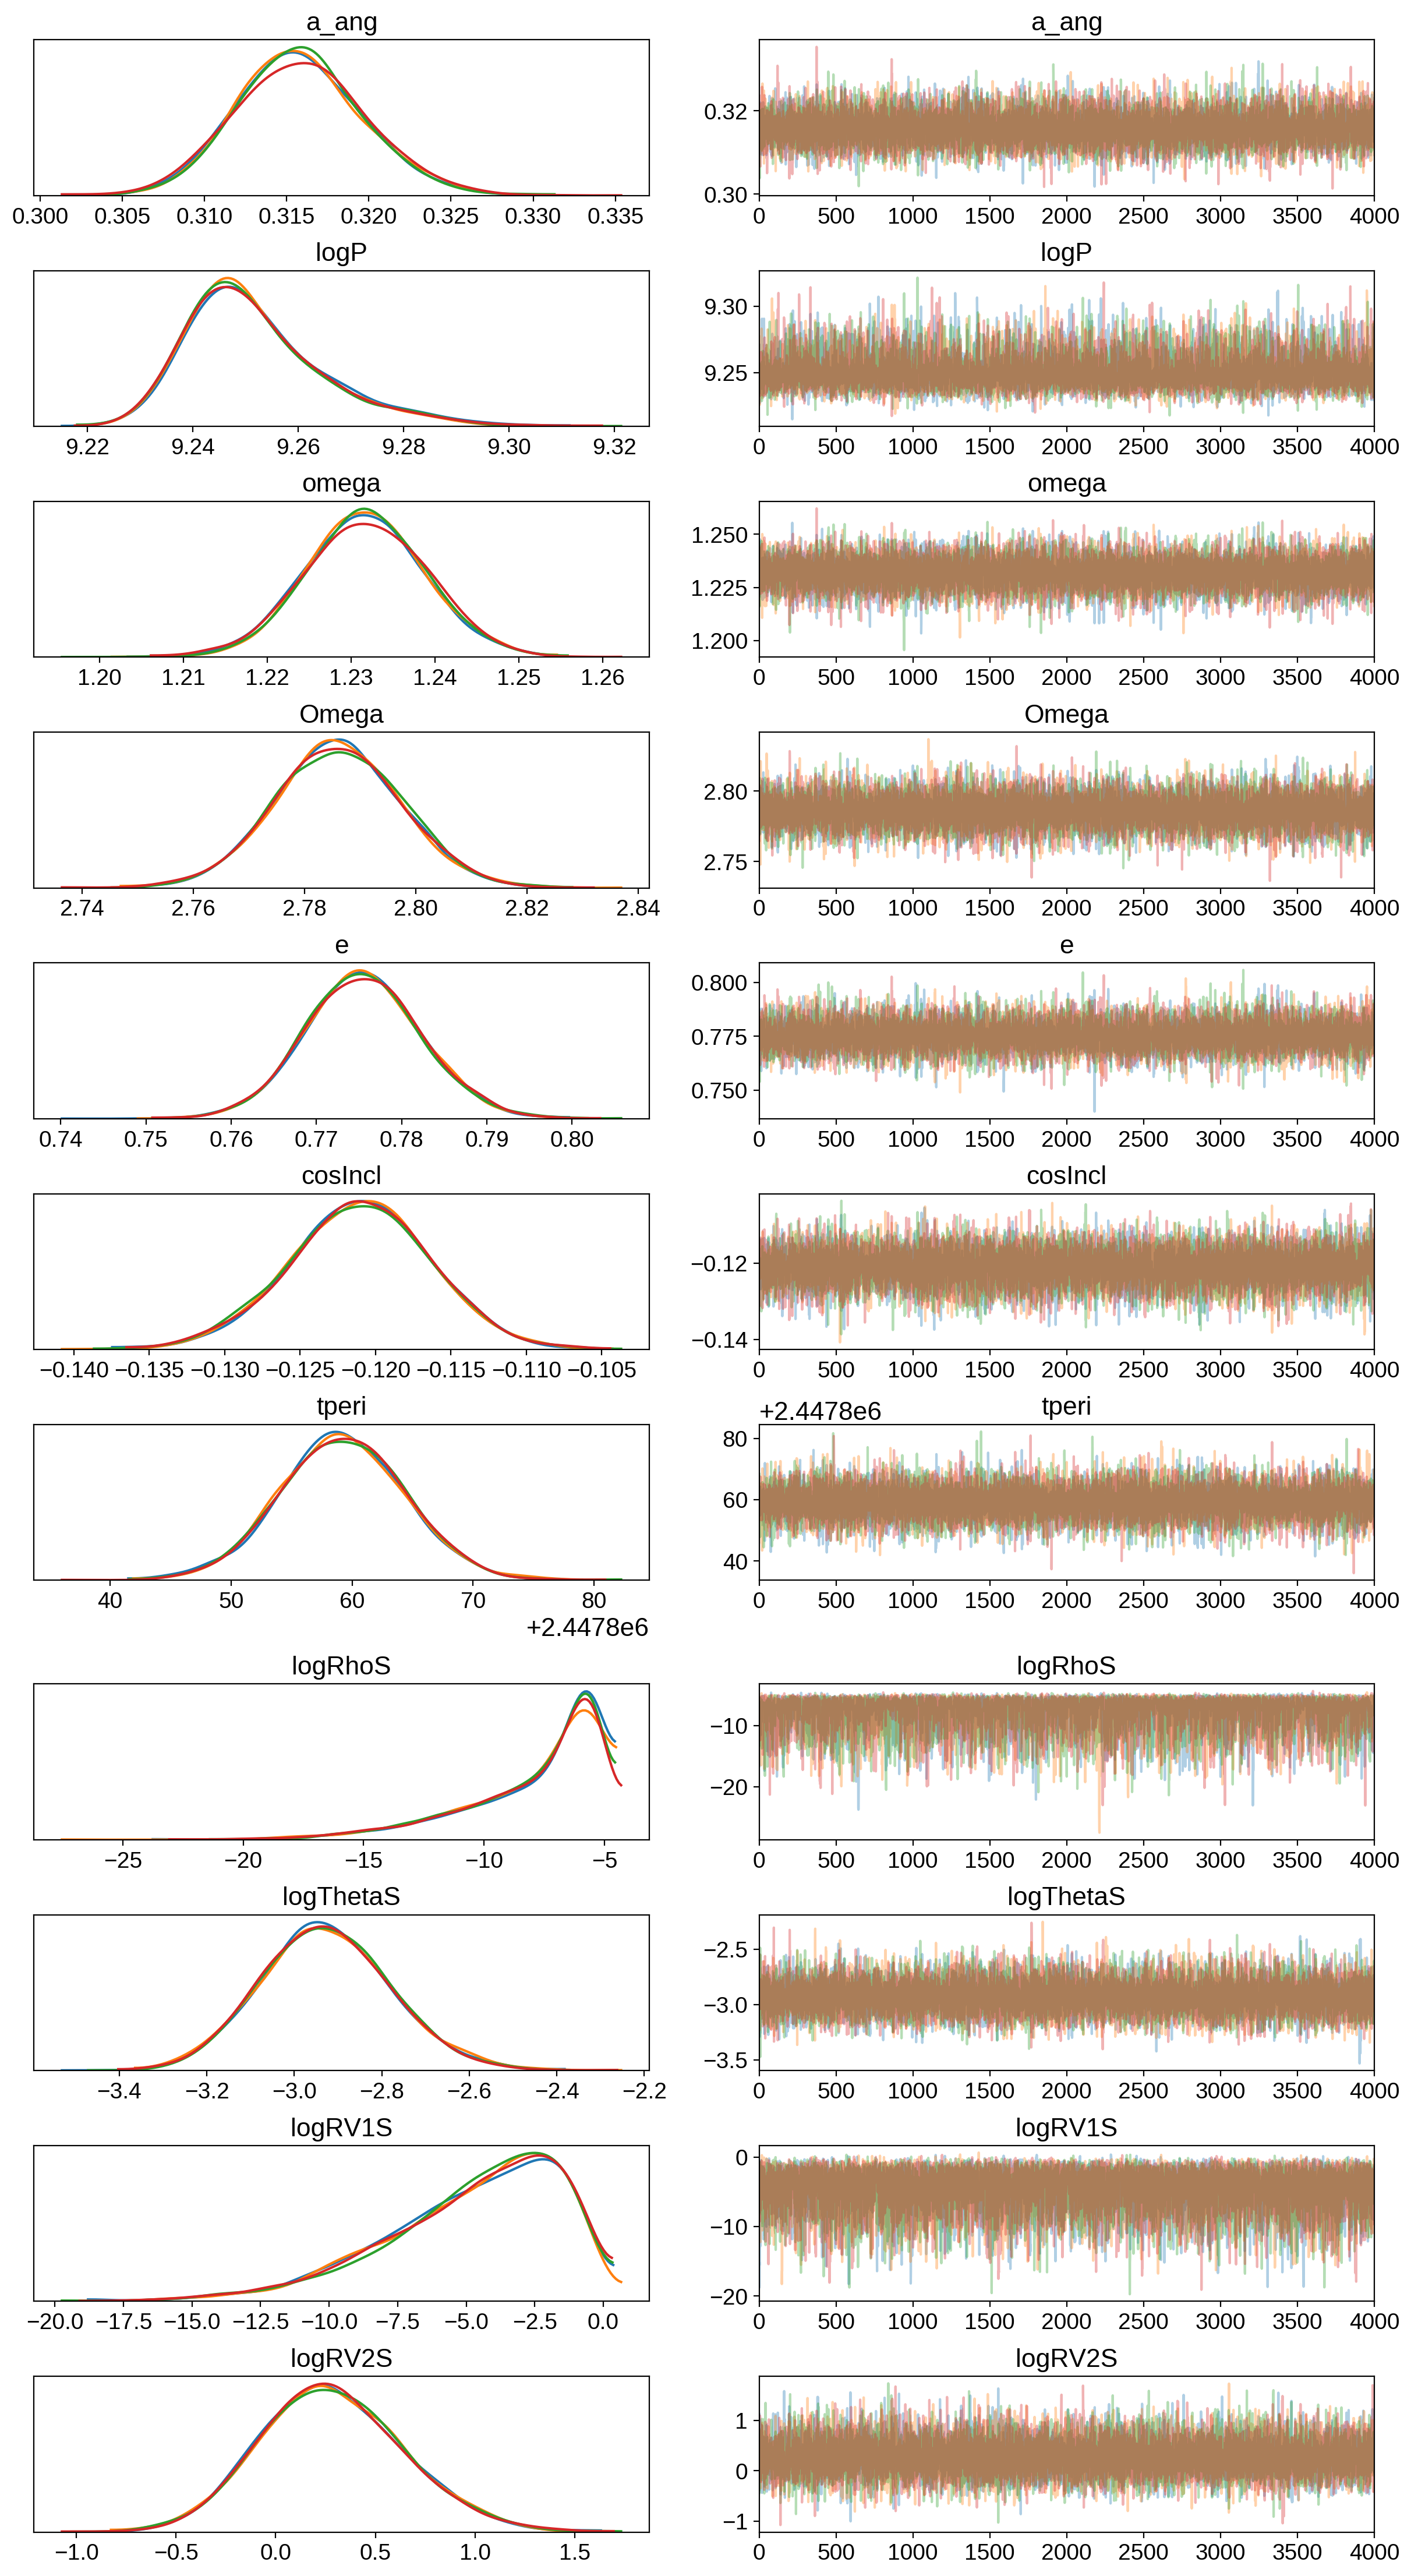

In [16]:
# let's examine the traces of the parameters we've sampled
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "cosIncl", "tperi", 
                              "logRhoS", "logThetaS", "logRV1S", "logRV2S"])

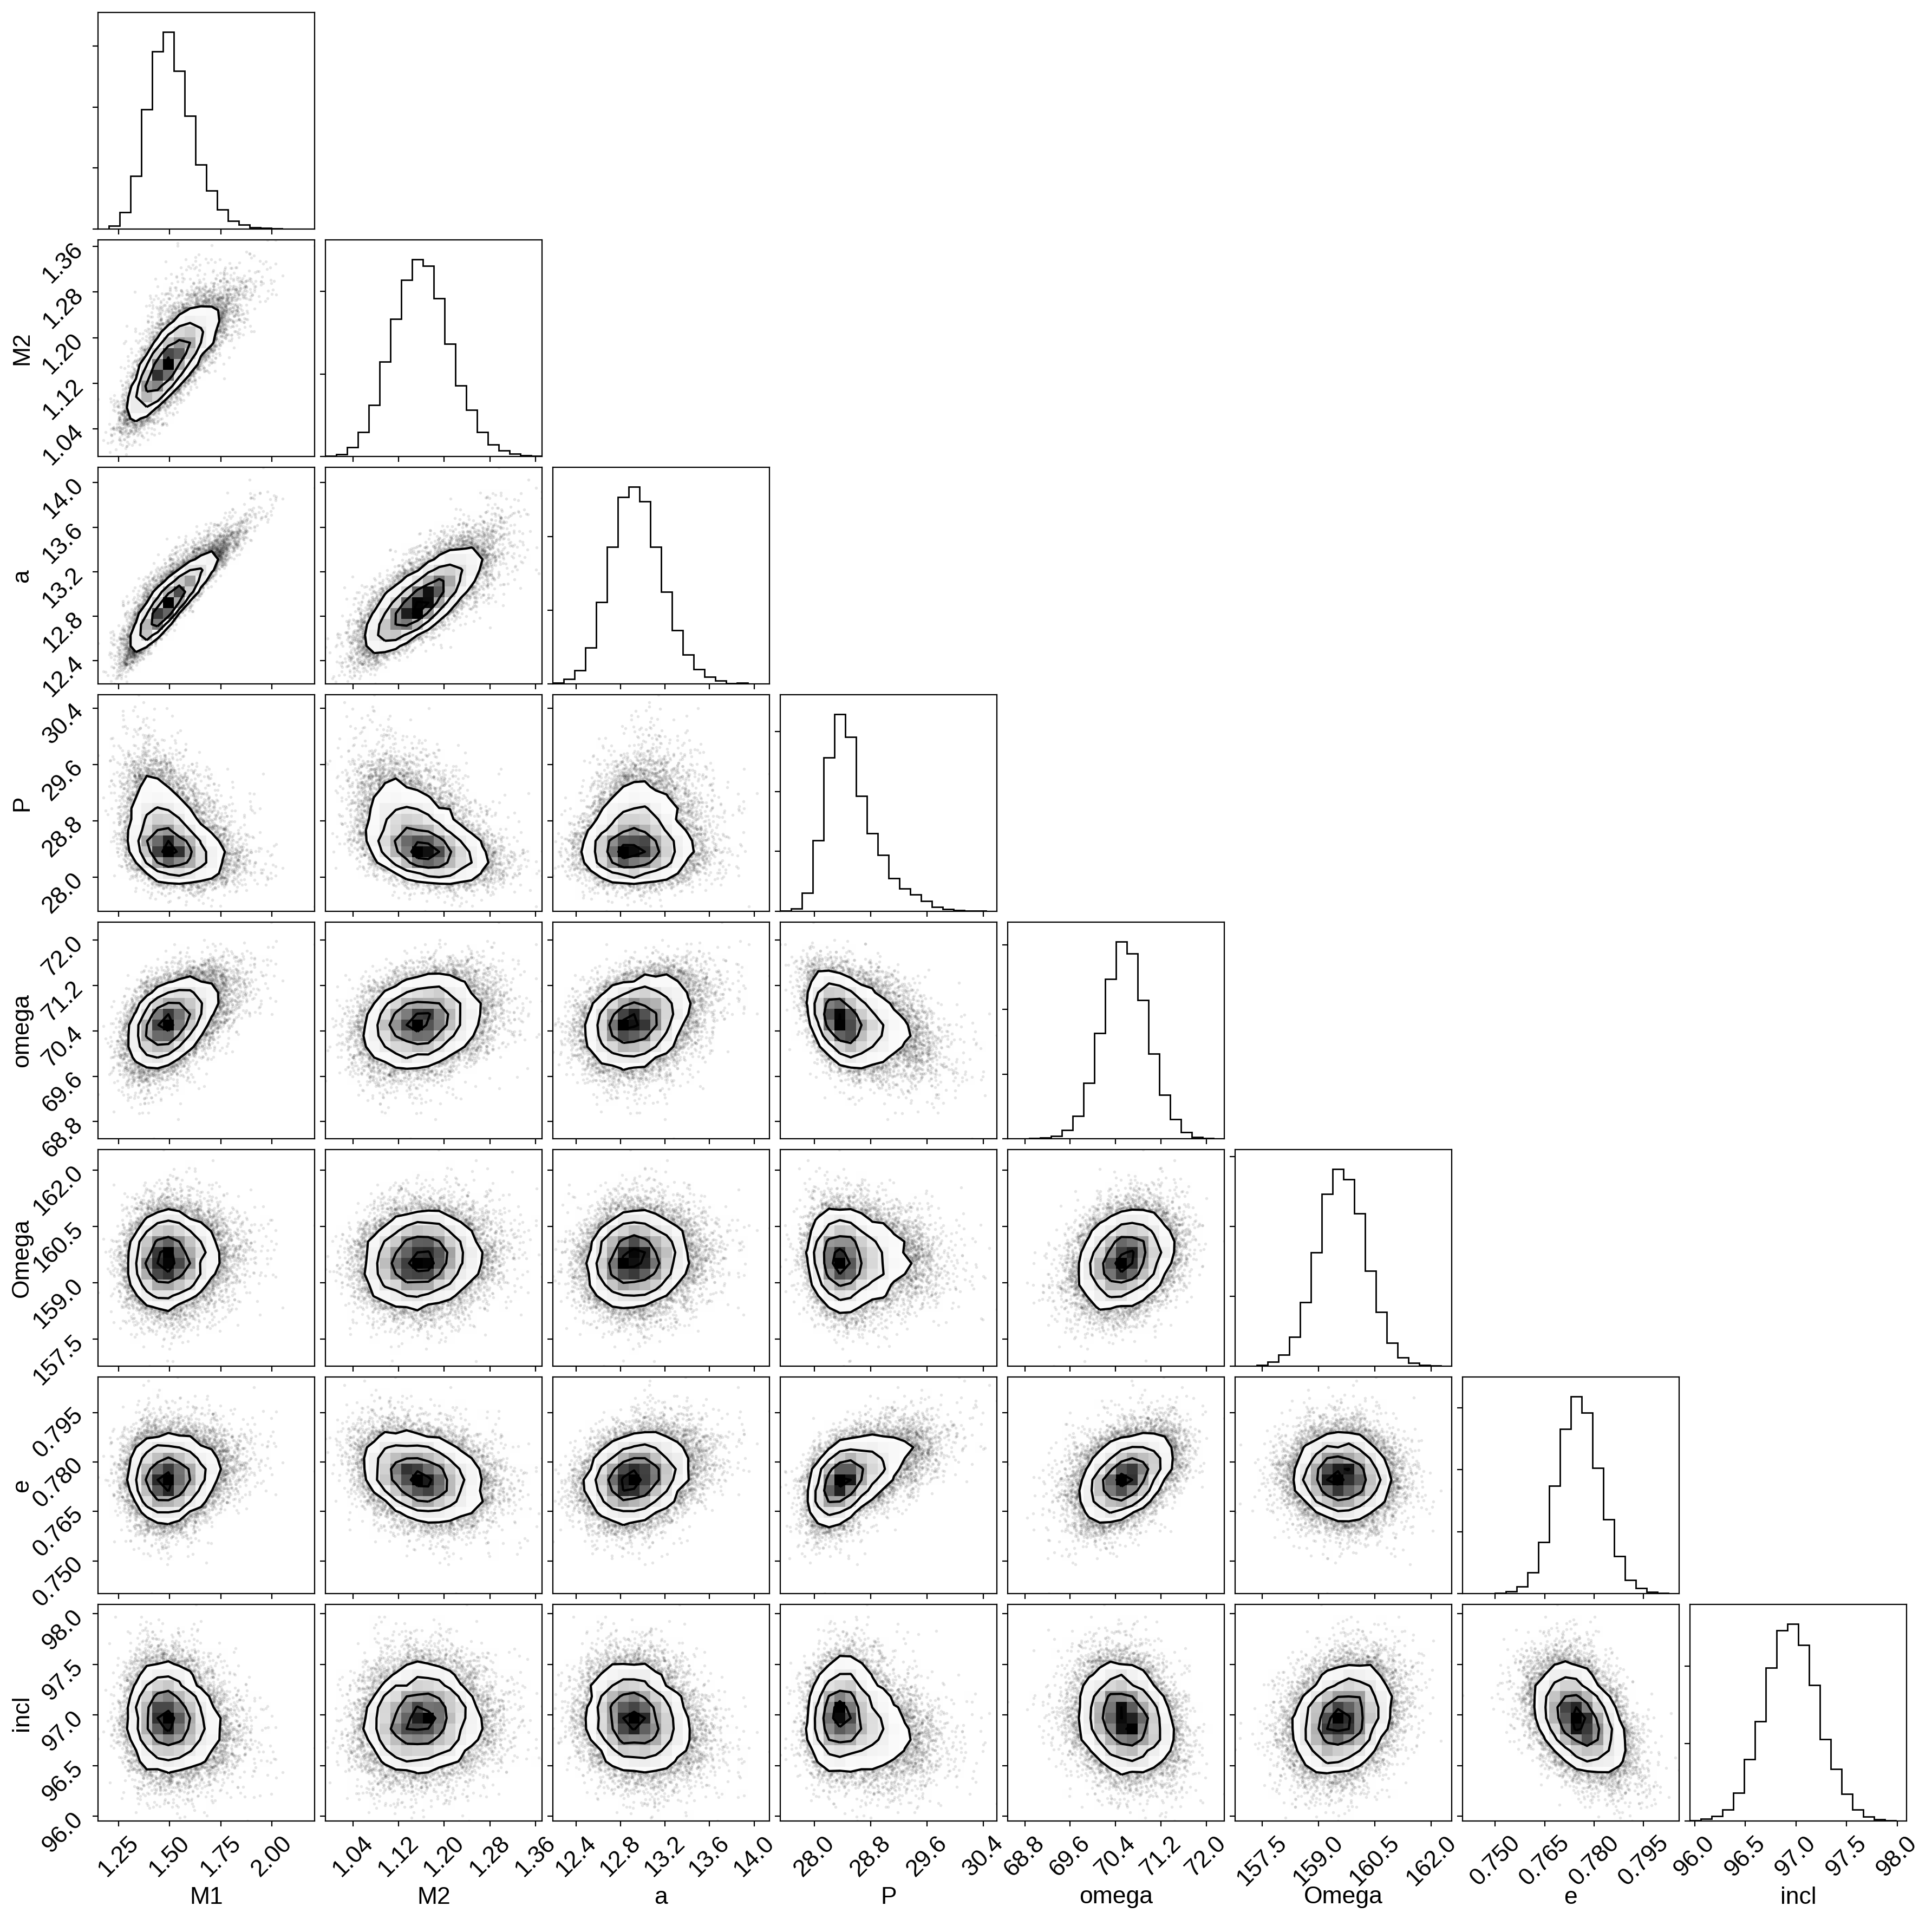

In [17]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["M1", "M2", "a", "P", "omega", "Omega", "e", "incl"])

samples["P"] /= yr
samples["incl"] /= deg
samples["omega"] /= deg
samples["Omega"] /= deg

corner.corner(samples);

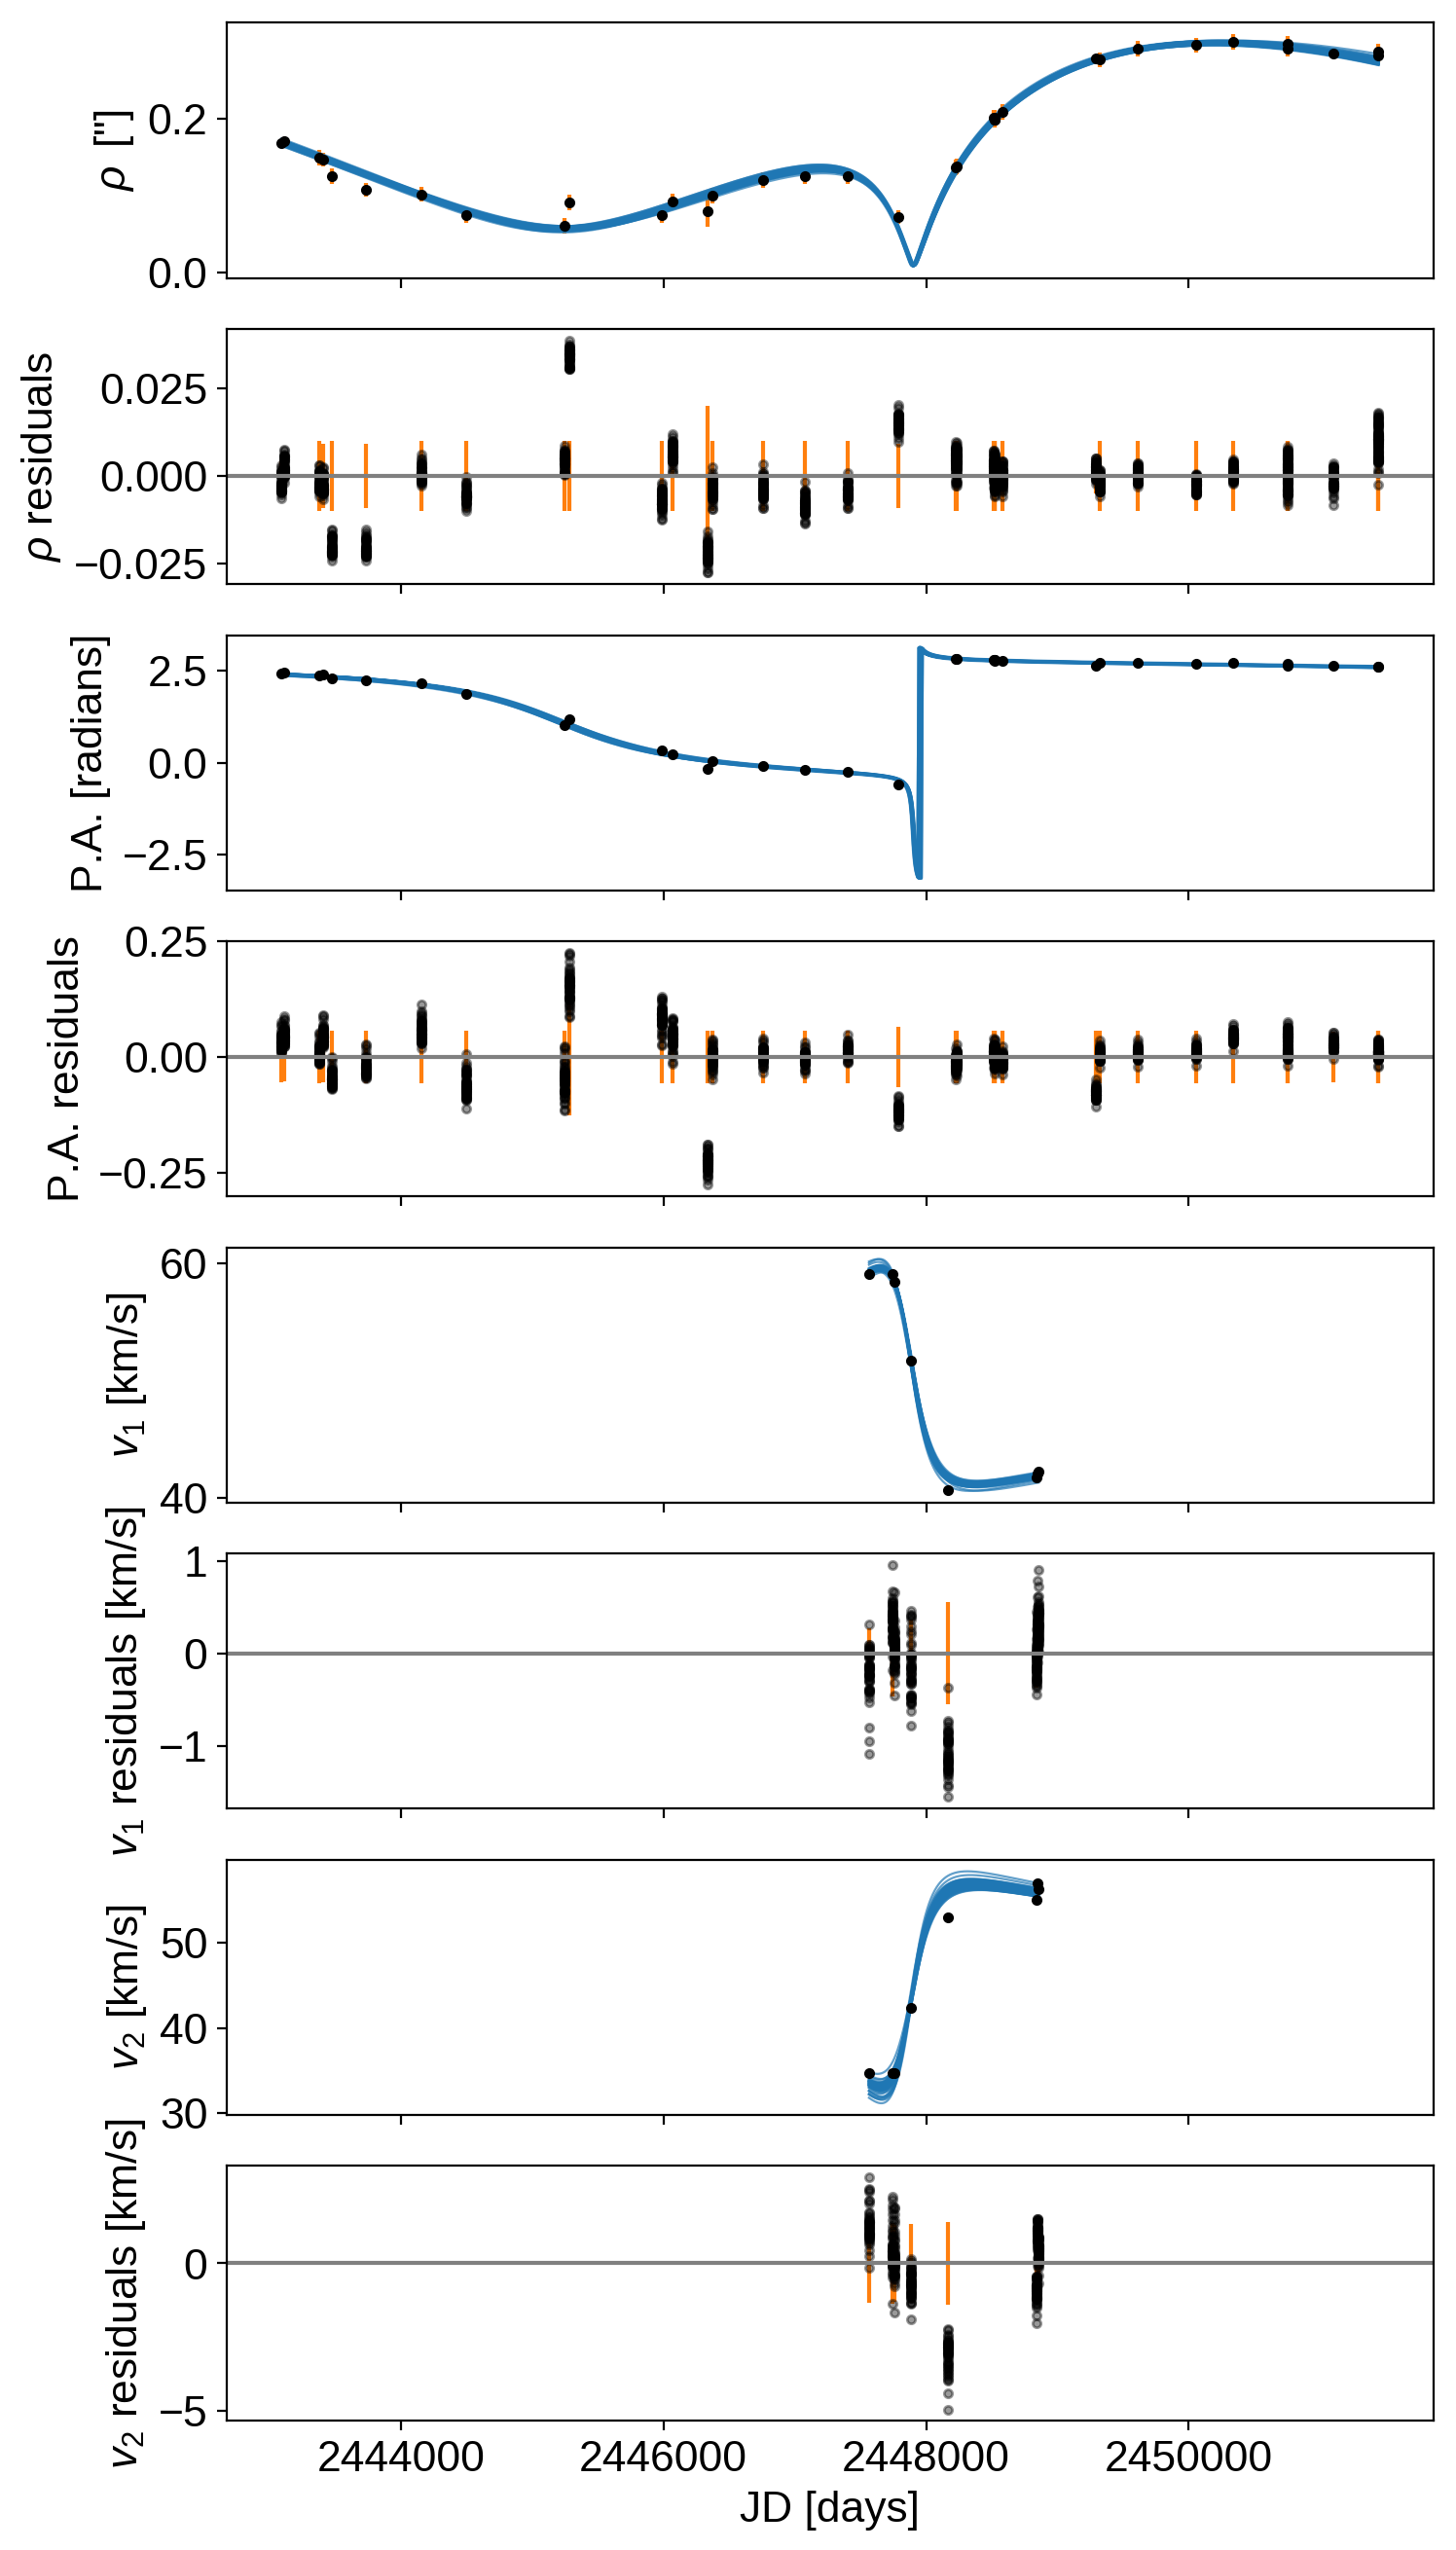

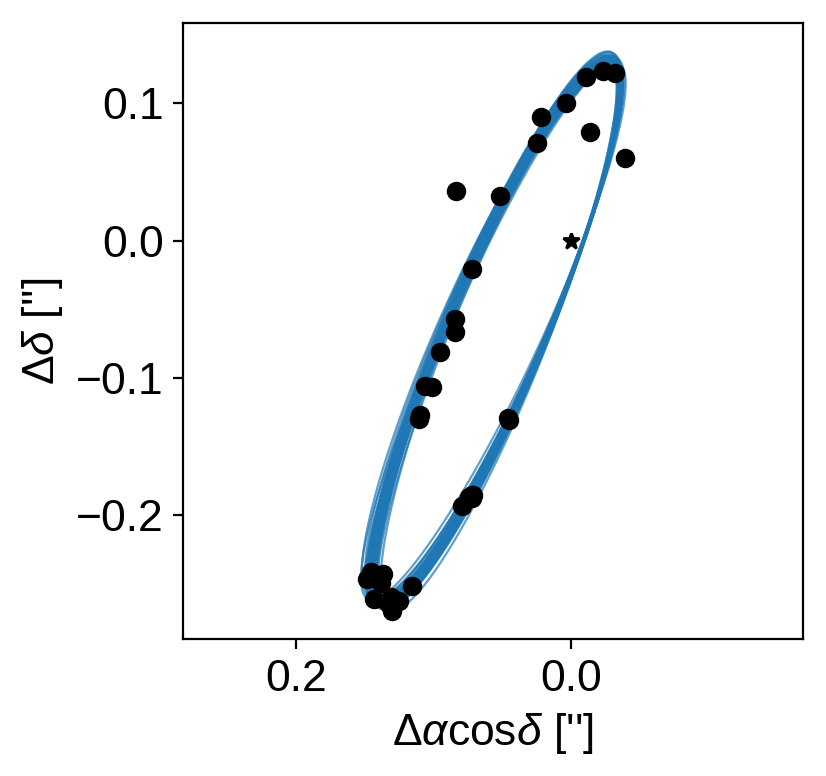

In [18]:
# plot the orbits on the figure

# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=8, sharex=True, figsize=(8,16))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

nsamples = 50
choices = np.random.choice(len(trace), size=nsamples)

# get map sol for tot_rho_err

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["logRhoS"])))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["logThetaS"])))

tot_rv1_err = np.sqrt(rv1_err**2 + np.exp(2 * np.median(trace["logRV1S"])))
tot_rv2_err = np.sqrt(rv2_err**2 + np.exp(2 * np.median(trace["logRV2S"])))
    

ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')
ax[4].set_ylabel(r'$v_1$ [km/s]')
ax[5].set_ylabel(r'$v_1$ residuals [km/s]')
ax[6].set_ylabel(r'$v_2$ [km/s]')
ax[7].set_ylabel(r'$v_2$ residuals [km/s]')
ax[7].set_xlabel("JD [days]")    


fig_sky, ax_sky = plt.subplots(nrows=1, figsize=(4,4))


with model:
    # iterate through trace object
    for i in choices:
        
        pos = trace[i] 
    
        rho_pred = pos["rhoSaveSky"]
        theta_pred = pos["thetaSaveSky"]

        x_pred = rho_pred * np.cos(theta_pred) # X north
        y_pred = rho_pred * np.sin(theta_pred) # Y east
    
        ax[0].plot(t_fine, pos["rhoSave"], color="C0", lw=0.8, alpha=0.7)
        
        ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, pos), **pkw, alpha=0.4)

        ax[2].plot(t_fine, pos["thetaSave"], color="C0", lw=0.8, alpha=0.7)

        ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, pos), **pkw, alpha=0.4)

        ax[4].plot(rv_times, pos["rv1Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[5].plot(rv1_jds, rv1 - xo.eval_in_model(rv1_model, pos), **pkw, alpha=0.4)
        
        ax[6].plot(rv_times, pos["rv2Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[7].plot(rv1_jds, rv2 - xo.eval_in_model(rv2_model, pos), **pkw, alpha=0.4)
        
        ax_sky.plot(y_pred, x_pred, color="C0", lw=0.8, alpha=0.7)
        
        

ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_rho_err, **ekw)

ax[2].plot(astro_jds, theta_data, **pkw)
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_theta_err, **ekw) 

ax[4].plot(rv1_jds, rv1, **pkw)

ax[5].axhline(0.0, color="0.5")
ax[5].errorbar(rv1_jds, np.zeros_like(rv1_jds), yerr=tot_rv1_err, **ekw)

ax[6].plot(rv2_jds, rv2, **pkw)

ax[7].axhline(0.0, color="0.5")
ax[7].errorbar(rv2_jds, np.zeros_like(rv2_jds), yerr=tot_rv2_err, **ekw)


xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax_sky.plot(ys, xs, "ko")
ax_sky.set_ylabel(r"$\Delta \delta$ ['']")
ax_sky.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax_sky.invert_xaxis()
ax_sky.plot(0,0, "k*")
ax_sky.set_aspect("equal", "datalim")